In [91]:
import pandas as pd
import numpy as np
import statsmodels as stm
import statsmodels.api as sm

import seaborn as sns
from datetime import date
import datetime
import matplotlib.pyplot as plt
import urllib
import zipfile
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st

In [2]:
import os
os.chdir("D:\Datasets")

In [78]:
def calculate_vol(x):
    return np.std(x)*np.sqrt(x.size)*100


def calculate_alt_vol(x):
    num = 0
    iter1=0
    for i in x:
        num=num+pow(i,2)
        iter1=iter1+1
    output=(pow(num/iter1,0.5))
    return output*np.sqrt(iter1)*100


def regression_capm(frame):
    x=frame.iloc[:,1]
    y=frame.iloc[:,0]
    ols = sm.OLS(y, x)
    ols_result = ols.fit()
    size=frame.shape[0]    
    output=np.sqrt(ols_result.mse_resid)*np.sqrt(size)*100
    return (output)

def regression_fama3(frame):
    x=frame.iloc[:,1:4]
    y=frame.iloc[:,0]
    ols = sm.OLS(y, x)
    ols_result = ols.fit()
    size=frame.shape[0]    
    output=np.sqrt(ols_result.mse_resid)*np.sqrt(size)*100
    return (output)

def regression_fama4(frame):
    x=frame.iloc[:,1:5]
    y=frame.iloc[:,0]
    ols = sm.OLS(y, x)
    ols_result = ols.fit()
    size=frame.shape[0]    
    output=np.sqrt(ols_result.mse_resid)*np.sqrt(size)*100
    return (output)


def calculate_fundamental_index_params(framef,factor,start,end):
    index_sample_f=framef.copy()
    index_sample_f.dropna(inplace=True)

    index_sample_f= index_sample_f[(index_sample_f['Market_Cap']>100000) & (index_sample_f['PRC'].abs()>5)]
    index_sample_f.sort_values(['year','cusip'],inplace=True)


    temp=index_sample_f.set_index('cusip')
    temp1=temp.groupby('year')[factor].nlargest(1000).reset_index()
    temp1.drop_duplicates(['cusip','year'],inplace=True)
    index_sample_final=temp1.merge(index_sample_f,how='inner',on=['cusip','year',factor])

    index_sample_final['weights']=index_sample_final.groupby('year')[factor].apply(lambda x: x/x.sum())
    index_sample_final['weights_m']=index_sample_final.groupby('year')['Market_Cap'].apply(lambda x: x/x.sum())

    factor_return=grouped_weighted_avg(index_sample_final.ret_a, index_sample_final.weights, index_sample_final.year)
    market_return=grouped_weighted_avg(index_sample_final.ret_a, index_sample_final.weights_m, index_sample_final.year)

    output=pd.concat([factor_return,market_return],axis=1).rename(columns={columns[0]:'factor_return',columns[1]:'market_return'})
    output.columns=['factor_return','market_return']

    output.reset_index(inplace=True)



    output_period= output[(output['year']>start-2)&(output['year']<end)]
    cumulative_return_factor=(np.cumprod(output_period['factor_return']+1)-1).tail(1).item()
    cumulative_return_market=(np.cumprod(output_period['market_return']+1)-1).tail(1).item()



    excess_returns=cumulative_return_factor-cumulative_return_market
    annualized_factor_returns=(pow((cumulative_return_factor+1),1/(output_period.shape[0]))-1)
    annualized_excess_returns=(pow((excess_returns+1),1/(output_period.shape[0]))-1)

    volatility=np.std(output_period['factor_return'])
    skewness=output_period['factor_return'].skew()
    kurtosis=output_period['factor_return'].kurtosis()


    sharpe=annualized_factor_returns/volatility
    information_ratio=annualized_excess_returns/np.std(output_period['factor_return']-output_period['market_return'])


    print("Parameters for factor: "+factor+" for period "+ str(start+1)+" to " + str(end) + " :")
    print("")
    print("Excess Return: "+str(excess_returns))
    print("Volatility: "+str(volatility))
    print("Skewness: "+str(skewness))
    print("Kurtosis: "+str(kurtosis))
    print("Sharpe Ratio: "+str(sharpe))
    print("Information Ratio: "+str(information_ratio))
    print("")



    plot_frame=index_sample_f.groupby('year')[['Mom_a','SMB_a','HMB_a']].mean()
    plot_frame=pd.concat([output.set_index('year')*100,plot_frame*100,nber_data],join='inner',axis=1)
    plot_frame.reset_index(inplace=True)
    plot_frame=plot_frame[(plot_frame['year']>start-2)&(plot_frame['year']<end)].set_index('year')
    plot_frame.columns=['Fundamental Factor Return','Market Return','Momentum Return', 'SMB Return','HMB Return','NBER']
    plot_frame.reset_index(inplace=True)
    ax = plot_frame.plot('year',['Fundamental Factor Return','Market Return','Momentum Return', 'SMB Return','HMB Return'],figsize=(20, 10))
    plot_frame.plot('year','NBER',secondary_y=True, ax=ax)
    plt.title("Factor: "+factor+" for period "+ str(start+1)+" to " + str(end))
    plt.show()
    
    plot_frame2=index_sample_f.groupby('year')[['Mom_a','SMB_a','HMB_a']].mean()
    plot_frame2=pd.concat([output.set_index('year')*100,plot_frame2*100],join='inner',axis=1)
    plot_frame2.reset_index(inplace=True)
    plot_frame2=plot_frame2[(plot_frame2['year']>start-2)&(plot_frame2['year']<end)].set_index('year')
    return plot_frame2

    
    
def grouped_weighted_avg(values, weights, by):
    return (values * weights).groupby(by).sum() / weights.groupby(by).sum()

## Loading & Transforming COMPUSTAT Data (Part 1 & 2)

In [4]:
columns = ['datadate','cusip','conm','gvkey', 'dltt','dlc','datafmt','indfmt','popsrc','consol','seq','mkvalt','teq','chech','sale','revt','dv','scf','capx','ivch','aqc','fuseo','sppe','siv','ivstch','ivaco','at','oiadp','lt','act','lct','ni','pi','dp','re','prcc_f','csho']


funda_data = pd.read_csv("funda.csv",usecols = columns)

data_subset = funda_data.loc[(funda_data["at"] - funda_data["lct"] != 0) & ((funda_data["dltt"] + funda_data["dlc"] + funda_data["seq"]) != 0) & (funda_data['sale'] > 0) & (funda_data['at'] != 0)]

final_funda_data = data_subset.loc[ ( data_subset["indfmt"] == 'INDL') & (data_subset['datafmt'] == 'STD') & (data_subset['popsrc'] == 'D') & (data_subset['consol']=='C')]

final_funda_data = final_funda_data[~final_funda_data['scf'].isin([4,5,6,'.'])]
final_funda_data['datadate'] = pd.to_datetime(data_subset['datadate'].astype(str), format="%Y-%m-%d")
final_funda_data = final_funda_data.sort_values(['datadate','cusip'])


final_funda_data['cusip'] = final_funda_data['cusip'].astype(str)
final_funda_data['cusip'] = final_funda_data['cusip'].apply(lambda x : x[0:6])

In [5]:
final_funda_data['Book_Value'] = final_funda_data['at']-final_funda_data['lt']
final_funda_data['Trailing_Cash_Flow'] = final_funda_data.groupby('cusip')['chech'].transform(lambda x: x.rolling(5,1).mean())
final_funda_data['Trailing_Gross_Sales'] = final_funda_data.groupby('cusip')['sale'].transform(lambda x: x.rolling(5,1).mean())
final_funda_data['Trailing_Gross_Revenue'] = final_funda_data.groupby('cusip')['revt'].transform(lambda x: x.rolling(5,1).mean())
final_funda_data['Trailing_Gross_Dividends'] = final_funda_data.groupby('cusip')['dv'].transform(lambda x: x.rolling(5,1).mean())

final_funda_data['Gross_Investments']=np.where(final_funda_data['scf'].isin([1.0,2.0,3.0]),(final_funda_data['capx']-final_funda_data['ivch']+final_funda_data['aqc']+final_funda_data['fuseo'] -final_funda_data['sppe']-final_funda_data['siv']),(final_funda_data['capx'] + final_funda_data['ivch']+final_funda_data['aqc']-final_funda_data['sppe'] - final_funda_data['siv']-final_funda_data['ivstch'] - final_funda_data['ivaco']))
final_funda_data['Trailing_Gross_Investments'] = final_funda_data.groupby('cusip')['Gross_Investments'].transform(lambda x: x.rolling(5,1).mean())


final_funda_data['moving_at'] = final_funda_data.groupby('cusip')['at'].transform(lambda x: x.rolling(2,1).mean())
final_funda_data['ROA'] = (final_funda_data['oiadp']/final_funda_data['moving_at'])
final_funda_data['Trailing_ROA'] = final_funda_data.groupby('cusip')['ROA'].transform(lambda x: x.rolling(5,1).mean())
final_funda_data['Asset_Turnover']=(final_funda_data['sale']/final_funda_data['moving_at'])




final_funda_data['Altman Z Score'] = (1.2 * (final_funda_data['act'] - final_funda_data['lct'])/final_funda_data['at']) + (1.4 * final_funda_data['re']/final_funda_data['at']) + (3.3 * final_funda_data['oiadp']/final_funda_data['at']) + (0.6 * (final_funda_data['prcc_f'] * final_funda_data['csho']/final_funda_data['lt'])) + (0.99 * final_funda_data['sale']/final_funda_data['at'])
final_funda_data['score_0'] = np.log10(final_funda_data['at'])
final_funda_data['score_1'] = final_funda_data['lt']/final_funda_data['at']
final_funda_data['score_2'] = (final_funda_data['act'] - final_funda_data['lct'])/final_funda_data['at']
final_funda_data['score_3'] = final_funda_data['lct']/final_funda_data['act']
final_funda_data['score_4'] = final_funda_data['ni']/final_funda_data['at']
final_funda_data['score_5'] = (final_funda_data['pi']+final_funda_data['dp'])/final_funda_data['lt']
final_funda_data['score_6'] = np.where(final_funda_data['lt']>final_funda_data['at'],1,0)
final_funda_data['score_7'] = np.where((final_funda_data.groupby('cusip')['ni'].shift(1)<0) &(final_funda_data.groupby('cusip')['ni'].shift(2)<0),1,0)
final_funda_data['score_8'] = (final_funda_data['ni'] - final_funda_data['ni'].shift(1))/(abs(final_funda_data['ni']) + abs(final_funda_data['ni'].shift(1)))

final_funda_data['O Score'] = (-1.32) -(0.407 * final_funda_data['score_0']) + (6.03 * final_funda_data['score_1']) - (1.43 * final_funda_data['score_2']) + (0.0757 * final_funda_data['score_3']) - (2.37 * final_funda_data['score_4']) -(1.83 * final_funda_data['score_5']) - (1.72 * final_funda_data['score_6']) + (0.285 * final_funda_data['score_7']) - (0.52 * final_funda_data['score_8'])

In [6]:
final_funda_data.rename(columns={'datadate':'date'},inplace=True)
final_funda_data['year']=final_funda_data['date'].dt.year
final_funda_data.drop_duplicates(['year','cusip'],inplace=True)

In [7]:
print(final_funda_data.shape)
print(final_funda_data['cusip'].nunique())

(428410, 60)
32913


## Loading & Transforming CRSP Data (Part 1 & 2)

In [8]:
monthly_data=pd.read_csv("CRSP_MSF.csv",usecols=['date','SHRCD','RET','CUSIP','PRC','vwretd','SHROUT'])

In [9]:
code = [10.0, 11.0]
monthly_data['date'] = pd.to_datetime(monthly_data['date'], format='%m/%d/%Y')
monthly_stock_sample = monthly_data.loc[(monthly_data['SHRCD'].isin(code))].rename(columns={'CUSIP':'cusip'})

In [10]:
monthly_stock_sample.head()

date  SHRCD     cusip      PRC        RET  SHROUT    vwretd
1 1986-01-31   10.0  68391610 -4.37500          C  3680.0  0.009830
2 1986-02-28   10.0  68391610 -3.25000  -0.257143  3680.0  0.072501
3 1986-03-31   10.0  68391610 -4.43750   0.365385  3680.0  0.053887
4 1986-04-30   10.0  68391610 -4.00000  -0.098592  3793.0 -0.007903
5 1986-05-30   10.0  68391610 -3.10938  -0.222656  3793.0  0.050847

In [11]:
monthly_stock_sample.set_index('date',inplace=True)

In [12]:
monthly_stock_sample.sort_values(["cusip","date"],inplace=True)
monthly_stock_sample['cusip'] = monthly_stock_sample['cusip'].astype(str)
monthly_stock_sample['cusip'] = monthly_stock_sample['cusip'].apply(lambda x : x[0:6])

In [13]:
monthly_stock_sample=monthly_stock_sample[monthly_stock_sample['PRC'].notna()]
monthly_stock_sample['RET']=pd.to_numeric(monthly_stock_sample['RET'], errors='coerce')
monthly_stock_sample=monthly_stock_sample[monthly_stock_sample['RET'].notna()]

In [14]:
monthly_stock_sample.shape

(3625382, 6)

In [15]:
monthly_stock_sample

SHRCD   cusip     PRC       RET   SHROUT    vwretd
date                                                          
1969-01-31   10.0  134810  19.000 -0.078788   1000.0 -0.006711
1969-02-28   10.0  134810  16.125 -0.151316   1000.0 -0.053641
1969-03-28   10.0  134810  16.250  0.007752   1000.0  0.030505
1969-04-30   10.0  134810  16.500  0.015385   1000.0  0.020527
1969-05-29   10.0  134810  15.000 -0.090909   1000.0  0.005040
...           ...     ...     ...       ...      ...       ...
2008-03-31   11.0  Y27183   7.720 -0.007712  49411.0 -0.010444
2008-04-30   11.0  Y27183   7.740  0.002591  49411.0  0.051199
2008-05-30   11.0  Y27183   7.850  0.014212  49411.0  0.023935
2008-06-30   11.0  Y27183   7.820 -0.003822  49411.0 -0.078436
2008-07-31   11.0  Y27183   7.810 -0.001279  49411.0 -0.013413

[3625382 rows x 6 columns]

## Loading & Transforming FamaFrench Data (Part 1 & 2)

In [16]:
url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip'
extract_dir = "D:\Datasets"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

In [17]:
fama_factors=pd.read_csv('F-F_Research_Data_Factors.csv',skiprows=2,nrows=1154)
fama_factors.rename(columns={fama_factors.columns[0]: 'date'},inplace=True)

fama_factors['date']=fama_factors['date'].apply(lambda x: datetime.datetime.strptime(str(x),"%Y%m"))

fama_factors['date'] = fama_factors['date'] + pd.offsets.MonthEnd(0)

fama_factors=fama_factors.set_index('date')/100

In [18]:
url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip'
extract_dir = "D:\Datasets"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

In [19]:
momentum_factor=pd.read_csv('F-F_Momentum_Factor.csv',skiprows=13,nrows=1149)
momentum_factor.rename(columns={momentum_factor.columns[0]: 'date'},inplace=True)
momentum_factor['date']=momentum_factor['date'].apply(lambda x: datetime.datetime.strptime(str(x),"%Y%m"))
momentum_factor['date'] = momentum_factor['date'] + pd.offsets.MonthEnd(0)
momentum_factor=momentum_factor.set_index('date')/100

In [20]:
final_monthly_data =momentum_factor.merge(fama_factors, on='date',how='inner')

In [21]:
final_monthly_data=final_monthly_data.merge(monthly_stock_sample, on='date',how='inner')

In [22]:
final_monthly_data.sort_values(['cusip','date'],inplace=True)

In [23]:
final_monthly_data.head()

Mom     Mkt-RF     SMB     HML      RF  SHRCD   cusip    PRC  \
date                                                                       
1970-12-31 -0.0223  0.0572  0.0292  0.0100  0.0042   10.0  000032  10.00   
1971-03-31 -0.0141  0.0413  0.0262 -0.0395  0.0030   10.0  000032   9.75   
1971-04-30  0.0141  0.0315 -0.0049  0.0069  0.0028   10.0  000032  10.75   
1971-06-30  0.0273 -0.0010 -0.0147 -0.0187  0.0037   10.0  000032   8.25   
1971-08-31  0.0361  0.0379 -0.0017  0.0263  0.0047   10.0  000032   5.25   

                 RET  SHROUT    vwretd  
date                                    
1970-12-31  0.111111  2655.0  0.060723  
1971-03-31 -0.123596  2655.0  0.044778  
1971-04-30  0.102564  2655.0  0.033332  
1971-06-30 -0.043478  2655.0  0.003119  
1971-08-31 -0.142857  2655.0  0.042511

In [24]:
final_monthly_data.reset_index(inplace=True)

In [25]:
shift_col1=['Mom   ', 'Mkt-RF', 'SMB', 'HML', 'RF', 'SHRCD', 'PRC', 'RET','SHROUT', 'vwretd']

In [26]:
final_monthly_data_shift=final_monthly_data.copy()

In [27]:
final_monthly_data_shift[shift_col1]=final_monthly_data.groupby('cusip')[shift_col1].shift()

In [28]:
#final_monthly_data_shift.isnull().sum()

In [29]:
final_monthly_data_shift.dropna(inplace=True)

In [30]:
final_monthly_data_shift.rename(columns={'Mom   ':'Mom'},inplace=True)

In [31]:
final_monthly_data_shift['Excess_Return']=final_monthly_data_shift['RET']-final_monthly_data_shift['RF']
final_monthly_data_shift['Market_Excess_Return']=final_monthly_data_shift['vwretd']-final_monthly_data_shift['RF']

In [32]:
final_monthly_data_shift

date     Mom  Mkt-RF     SMB     HML      RF  SHRCD   cusip  \
1       1971-03-31 -0.0223  0.0572  0.0292  0.0100  0.0042   10.0  000032   
2       1971-04-30 -0.0141  0.0413  0.0262 -0.0395  0.0030   10.0  000032   
3       1971-06-30  0.0141  0.0315 -0.0049  0.0069  0.0028   10.0  000032   
4       1971-08-31  0.0273 -0.0010 -0.0147 -0.0187  0.0037   10.0  000032   
5       1971-09-30  0.0361  0.0379 -0.0017  0.0263  0.0047   10.0  000032   
...            ...     ...     ...     ...     ...     ...    ...     ...   
2562217 2008-02-29 -0.0775 -0.0636 -0.0104  0.0398  0.0021   11.0  Y27183   
2562218 2008-03-31  0.0610 -0.0309 -0.0043 -0.0084  0.0013   11.0  Y27183   
2562219 2008-04-30  0.0427 -0.0093  0.0071  0.0030  0.0017   11.0  Y27183   
2562220 2008-06-30 -0.0031  0.0460 -0.0165 -0.0104  0.0018   11.0  Y27183   
2562221 2008-07-31  0.1275 -0.0844  0.0120 -0.0267  0.0017   11.0  Y27183   

           PRC       RET   SHROUT    vwretd  Excess_Return  \
1        10.00  0.111111   2655.0  0.060723       0.106911   
2         9.75 -0.123596   2655.0  0.044778      -0.126596   
3        10.75  0.102564   2655.0  0.033332       0.099764   
4         8.25 -0.043478   2655.0  0.003119      -0.047178   
5         5.25 -0.142857   2655.0  0.042511      -0.147557   
...        ...       ...      ...       ...            ...   
2562217   7.90  0.015424  49411.0 -0.062218       0.013324   
2562218   7.78 -0.015190  49411.0 -0.021697      -0.016490   
2562219   7.72 -0.007712  49411.0 -0.010444      -0.009412   
2562220   7.74  0.002591  49411.0  0.051199       0.000791   
2562221   7.82 -0.003822  49411.0 -0.078436      -0.005522   

         Market_Excess_Return  
1                    0.056523  
2                    0.041778  
3                    0.030532  
4                   -0.000581  
5                    0.037811  
...                       ...  
2562217             -0.064318  
2562218             -0.022997  
2562219             -0.012144  
2562220              0.049399  
2562221             -0.080136  

[2536394 rows x 14 columns]

## Loading & Transforming NBER Data

In [33]:
nber_data=pd.read_csv("USREC.csv",parse_dates=['DATE'],index_col='DATE')
nber_data= nber_data.resample('A').last()
nber_data.reset_index(inplace=True)
nber_data['year']=nber_data.DATE.dt.year
nber_data.drop(columns='DATE',inplace=True)
nber_data.set_index('year',inplace=True)

## Calculating 12 Month Beta & Total Volatility (Part 3)

In [34]:
temp_new=final_monthly_data_shift.groupby('cusip')[['Market_Excess_Return','Excess_Return']].rolling(12).cov()
final_monthly_data_shift["Cov"]=temp_new.groupby(level=[0,1]).last()['Market_Excess_Return'].reset_index(0,drop=True)
final_monthly_data_shift["Market_Std"]=final_monthly_data_shift.groupby('cusip')["Market_Excess_Return"].rolling(12).var().reset_index(0,drop=True)
final_monthly_data_shift['Beta']=final_monthly_data_shift["Cov"]/final_monthly_data_shift["Market_Std"]

In [36]:
final_monthly_data_shift["year"]=final_monthly_data_shift['date'].dt.year  
dates=final_monthly_data_shift.groupby(by='year')['date'].min().reset_index(drop=True).to_list()

In [37]:
final_monthly_data_shift['temp1']=final_monthly_data_shift['RET']+1
final_monthly_data_shift['temp2']=final_monthly_data_shift['vwretd']+1
final_monthly_data_shift['temp3']=final_monthly_data_shift['Mom']+1
final_monthly_data_shift['temp4']=final_monthly_data_shift['SMB']+1
final_monthly_data_shift['temp5']=final_monthly_data_shift['HML']+1
final_monthly_data_shift['temp6']=final_monthly_data_shift['RF']+1
final_monthly_data_shift['temp7']=final_monthly_data_shift['Excess_Return']+1
final_monthly_data_shift['temp8']=final_monthly_data_shift['Market_Excess_Return']+1


final_monthly_data_shift['ret_a']=final_monthly_data_shift.groupby(['cusip','year'])['temp1'].cumprod() -1
final_monthly_data_shift['vwretd_a']=final_monthly_data_shift.groupby(['cusip','year'])['temp2'].cumprod() -1
final_monthly_data_shift['Mom_a']=final_monthly_data_shift.groupby(['cusip','year'])['temp3'].cumprod() -1
final_monthly_data_shift['SMB_a']=final_monthly_data_shift.groupby(['cusip','year'])['temp4'].cumprod() -1
final_monthly_data_shift['HMB_a']=final_monthly_data_shift.groupby(['cusip','year'])['temp5'].cumprod() -1
final_monthly_data_shift['RF_a']=final_monthly_data_shift.groupby(['cusip','year'])['temp6'].cumprod() -1
final_monthly_data_shift['Excess_Return']=final_monthly_data_shift.groupby(['cusip','year'])['temp7'].cumprod() -1
final_monthly_data_shift['Market_Excess_Return']=final_monthly_data_shift.groupby(['cusip','year'])['temp8'].cumprod() -1

In [38]:
final_monthly_data_shift.drop(columns=['temp1','temp2','temp3','temp4','temp5','temp6','temp7','temp8'],inplace=True)

In [39]:
final_monthly_data_shift.drop_duplicates(['date','cusip'],inplace=True)

In [40]:
final_monthly_data_shift.shape

(2514466, 24)

In [41]:
Total_Vol=final_monthly_data_shift.groupby(['cusip','year'])["Excess_Return"].apply(calculate_vol).reset_index()
Total_Vol.rename(columns={'Excess_Return':'Total_Vol_a'},inplace=True)

In [42]:
Alt_Total_Vol=final_monthly_data_shift.groupby(['cusip','year'])["Excess_Return"].apply(calculate_alt_vol).reset_index()
Alt_Total_Vol.rename(columns={'Excess_Return':'Alt_Total_Vol_a'},inplace=True)

In [43]:
final_monthly_data_shift_annual=final_monthly_data_shift[final_monthly_data_shift['date'].isin(dates)]

In [44]:
annual_col_list=['cusip','year', 'PRC','SHROUT', 'Market_Std', 'Beta','ret_a', 'vwretd_a', 'Mom_a', 'SMB_a', 'HMB_a', 'RF_a']

In [45]:
final_monthly_data_shift_annual_subset=final_monthly_data_shift_annual.loc[:,annual_col_list]

In [46]:
final_monthly_data_shift_annual_subset=final_monthly_data_shift_annual_subset.merge(Total_Vol,how='inner',on=['year','cusip'])

In [47]:
final_monthly_data_shift_annual_subset=final_monthly_data_shift_annual_subset.merge(Alt_Total_Vol,how='inner',on=['year','cusip'])

In [48]:
final_monthly_data_shift_annual_subset

cusip  year     PRC   SHROUT  Market_Std      Beta     ret_a  \
0       000032  1971  10.000   2655.0         NaN       NaN  0.111111   
1       000032  1972   5.750   2655.0         NaN       NaN  0.393939   
2       000032  1973   5.500   2655.0    0.000930  3.227224 -0.022222   
3       000032  1974   1.750   2655.0    0.002491  2.593249  0.000000   
4       000032  1975   2.125   2217.0    0.005435  1.257625 -0.055556   
...        ...   ...     ...      ...         ...       ...       ...   
295180  U72603  2015   2.080  55178.0    0.000703  0.276752  0.264284   
295181  U72603  2016   3.050  52586.0    0.000507 -0.885558  0.070175   
295182  U72603  2017   4.020  48902.0    0.001139  1.725882  0.151862   
295183  Y27183  2007   7.440  49411.0         NaN       NaN  0.033333   
295184  Y27183  2008   7.780  49411.0         NaN       NaN -0.016435   

        vwretd_a   Mom_a   SMB_a   HMB_a    RF_a  Total_Vol_a  Alt_Total_Vol_a  
0       0.060723 -0.0223  0.0292  0.0100  0.0042    41.848058        47.429813  
1       0.091257 -0.0058  0.0329 -0.0040  0.0037    39.387639        64.434497  
2       0.049764 -0.0509 -0.0120  0.0485  0.0037    64.734206       121.142373  
3       0.011437  0.1038 -0.0535  0.0385  0.0064    62.946574        86.084512  
4      -0.027005  0.0292 -0.0483  0.0011  0.0070   112.698796       159.933219  
...          ...     ...     ...     ...     ...          ...              ...  
295180 -0.003662  0.0112  0.0249  0.0227  0.0000    58.457774       183.675223  
295181 -0.022227  0.0336 -0.0282 -0.0261  0.0001    45.591338        72.313040  
295182  0.040543 -0.0462  0.0567  0.0819  0.0001    35.112624        38.486201  
295183  0.023736 -0.0103  0.0070  0.0014  0.0042     1.502700         7.712371  
295184 -0.004405  0.0663  0.0012 -0.0054  0.0027     2.454906         6.463023  

[295185 rows x 14 columns]

In [49]:
#final_monthly_data_shift_annual.set_index('year',inplace=True)

## Calculating Idiosyncratic volatility (Part 4A)

In [50]:
idio_data=final_monthly_data_shift.copy()

In [51]:
idio_1=idio_data.groupby(['year','cusip'])[['Excess_Return','Market_Excess_Return']].apply(regression_capm).reset_index()

In [52]:
idio_1.columns=['year','cusip','Idio_CAPM_Vol_a']

In [53]:
idio_2=idio_data.groupby(['year','cusip'])[['Excess_Return','Market_Excess_Return','SMB','HML']].apply(regression_fama3).reset_index()

In [54]:
idio_2.columns=['year','cusip','Idio_Fama3_Vol_a']

In [55]:
idio_3=idio_data.groupby(['year','cusip'])[['Excess_Return','Market_Excess_Return','SMB','HML','Mom']].apply(regression_fama4).reset_index()

In [56]:
idio_3.columns=['year','cusip','Idio_Fama4_Vol_a']

In [57]:
idio_data_annual=final_monthly_data_shift_annual_subset.merge(idio_1,how='inner',on=['year','cusip'])

In [58]:
idio_data_annual=idio_data_annual.merge(idio_2,how='inner',on=['year','cusip'])

In [59]:
idio_data_annual=idio_data_annual.merge(idio_3,how='inner',on=['year','cusip'])

In [60]:
idio_data_annual

cusip  year     PRC   SHROUT  Market_Std      Beta     ret_a  \
0       000032  1971  10.000   2655.0         NaN       NaN  0.111111   
1       000032  1972   5.750   2655.0         NaN       NaN  0.393939   
2       000032  1973   5.500   2655.0    0.000930  3.227224 -0.022222   
3       000032  1974   1.750   2655.0    0.002491  2.593249  0.000000   
4       000032  1975   2.125   2217.0    0.005435  1.257625 -0.055556   
...        ...   ...     ...      ...         ...       ...       ...   
295180  U72603  2015   2.080  55178.0    0.000703  0.276752  0.264284   
295181  U72603  2016   3.050  52586.0    0.000507 -0.885558  0.070175   
295182  U72603  2017   4.020  48902.0    0.001139  1.725882  0.151862   
295183  Y27183  2007   7.440  49411.0         NaN       NaN  0.033333   
295184  Y27183  2008   7.780  49411.0         NaN       NaN -0.016435   

        vwretd_a   Mom_a   SMB_a   HMB_a    RF_a  Total_Vol_a  \
0       0.060723 -0.0223  0.0292  0.0100  0.0042    41.848058   
1       0.091257 -0.0058  0.0329 -0.0040  0.0037    39.387639   
2       0.049764 -0.0509 -0.0120  0.0485  0.0037    64.734206   
3       0.011437  0.1038 -0.0535  0.0385  0.0064    62.946574   
4      -0.027005  0.0292 -0.0483  0.0011  0.0070   112.698796   
...          ...     ...     ...     ...     ...          ...   
295180 -0.003662  0.0112  0.0249  0.0227  0.0000    58.457774   
295181 -0.022227  0.0336 -0.0282 -0.0261  0.0001    45.591338   
295182  0.040543 -0.0462  0.0567  0.0819  0.0001    35.112624   
295183  0.023736 -0.0103  0.0070  0.0014  0.0042     1.502700   
295184 -0.004405  0.0663  0.0012 -0.0054  0.0027     2.454906   

        Alt_Total_Vol_a  Idio_CAPM_Vol_a  Idio_Fama3_Vol_a  Idio_Fama4_Vol_a  
0             47.429813        39.735306         39.578766         45.605827  
1             64.434497        49.098922         25.606725         28.604674  
2            121.142373        32.465630         28.703985         31.379309  
3             86.084512        90.128331        103.482728         99.477789  
4            159.933219       107.243840        106.303677        115.691356  
...                 ...              ...               ...               ...  
295180       183.675223        98.823014        114.602031        125.194435  
295181        72.313040        42.642706         35.527888         36.808247  
295182        38.486201        39.606449         44.884465         43.576089  
295183         7.712371         4.156192          4.757274          4.699608  
295184         6.463023         2.919511          2.859017          2.976951  

[295185 rows x 17 columns]

In [61]:
annual_col_list2=['cusip','year', 'PRC','SHROUT', 'Market_Std', 'Beta','ret_a', 'vwretd_a', 'Mom_a', 'SMB_a', 'HMB_a', 'RF_a']

## Creating fundamental Indexes (Part 4B)

In [62]:
col_required=['year','cusip','Book_Value','Trailing_Cash_Flow','Trailing_Gross_Sales','Trailing_Gross_Revenue','Trailing_Gross_Dividends','Trailing_Gross_Investments','Trailing_ROA','Asset_Turnover','Altman Z Score','O Score']

In [63]:
final_funda_data_sample=final_funda_data[col_required].sort_values(['cusip','year'])

In [64]:
shift_col2=['Book_Value','Trailing_Cash_Flow','Trailing_Gross_Sales','Trailing_Gross_Revenue','Trailing_Gross_Dividends','Trailing_Gross_Investments','Trailing_ROA','Asset_Turnover','Altman Z Score','O Score']

In [65]:
final_funda_data_sample_shift=final_funda_data_sample.copy()
final_funda_data_sample_shift[shift_col2]=final_funda_data_sample.groupby('cusip')[shift_col2].shift()

In [66]:
final_funda_data_sample_shift=final_funda_data_sample_shift.loc[final_funda_data['year']>1968]

In [67]:
final_funda_data_sample_shift

year   cusip  Book_Value  Trailing_Cash_Flow  Trailing_Gross_Sales  \
461776  1985  000021         NaN                 NaN                   NaN   
461777  1986  000021       0.726                 NaN               3.42200   
461778  1987  000021       0.693           -0.012000               4.29900   
461780  1989  000021       1.155           -0.001000               5.14400   
461781  1990  000021       1.500           -0.006667               6.27025   
...      ...     ...         ...                 ...                   ...   
503922  2020  Y95308      71.606           29.230000               7.14760   
729094  2000     nan         NaN                 NaN                   NaN   
729095  2001     nan      27.308           -2.003000             180.22400   
815665  2008     nan      41.367            2.277000             191.41700   
815666  2009     nan      -2.567            1.369000             241.30200   

        Trailing_Gross_Revenue  Trailing_Gross_Dividends  \
461776                     NaN                       NaN   
461777                 3.42200                    0.0000   
461778                 4.29900                    0.0750   
461780                 5.14400                    0.0500   
461781                 6.27025                    0.0375   
...                        ...                       ...   
503922                 7.14760                    0.0000   
729094                     NaN                       NaN   
729095               180.22400                    0.0000   
815665               191.41700                    0.0000   
815666               241.30200                    0.0000   

        Trailing_Gross_Investments  Trailing_ROA  Asset_Turnover  \
461776                         NaN           NaN             NaN   
461777                    0.247000      0.104553        1.923553   
461778                    0.146000      0.130671        2.750997   
461780                    0.111667      0.128366        3.240398   
461781                    0.289000      0.132317        3.280857   
...                            ...           ...             ...   
503922                    8.764600     -0.485885        0.055096   
729094                         NaN           NaN             NaN   
729095                   24.961000      0.008258        1.283007   
815665                   17.223000      0.037123        1.340865   
815666                   11.977333      0.064326        3.049888   

        Altman Z Score   O Score  
461776             NaN       NaN  
461777             NaN  1.142580  
461778             NaN  1.320952  
461780        5.565801  0.107388  
461781        4.573355  1.803419  
...                ...       ...  
503922       -3.927553  5.848766  
729094             NaN       NaN  
729095             NaN  3.212843  
815665             NaN  2.567186  
815666             NaN  2.106592  

[394679 rows x 12 columns]

In [68]:
index_sample=final_monthly_data_shift_annual_subset.merge(final_funda_data_sample_shift,how='inner',on=['year','cusip'])
index_sample['Market_Cap']=index_sample['SHROUT'].abs()*index_sample['PRC'].abs()

In [69]:
factor_list=['Book_Value','Trailing_Cash_Flow','Trailing_Gross_Sales','Trailing_Gross_Revenue','Trailing_Gross_Dividends','Trailing_Gross_Investments','Trailing_ROA','Asset_Turnover','Altman Z Score','O Score']

start1=1969
end1=2020

start2=1969
end2=2000

start3=2000
end3=2020

In [79]:
frame_list=[]

Parameters for factor: Book_Value for period 1970 to 2020 :

Excess Return: -0.6561954995626817
Volatility: 0.05026983617592507
Skewness: -1.0021290422304054
Kurtosis: 1.343473913583395
Sharpe Ratio: 0.3009727772023685
Information Ratio: -1.3073918750475761



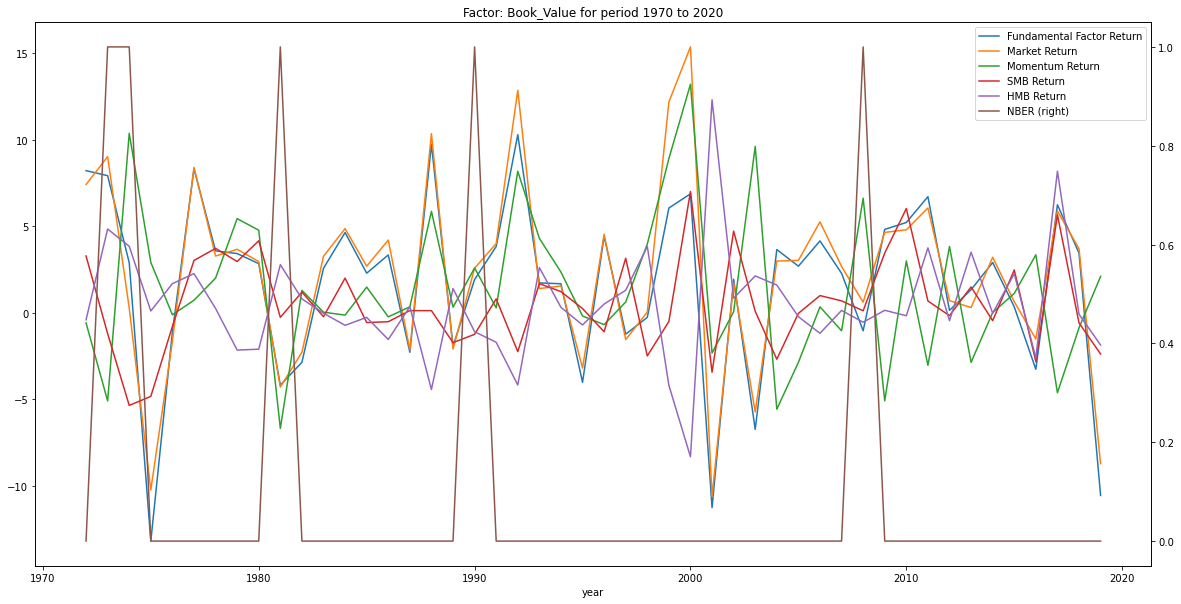

Parameters for factor: Book_Value for period 1970 to 2000 :

Excess Return: -0.24057864377145832
Volatility: 0.048986935254660156
Skewness: -0.8461985665173918
Kurtosis: 1.9806749355513062
Sharpe Ratio: 0.40391080407331587
Information Ratio: -0.6719589638270606



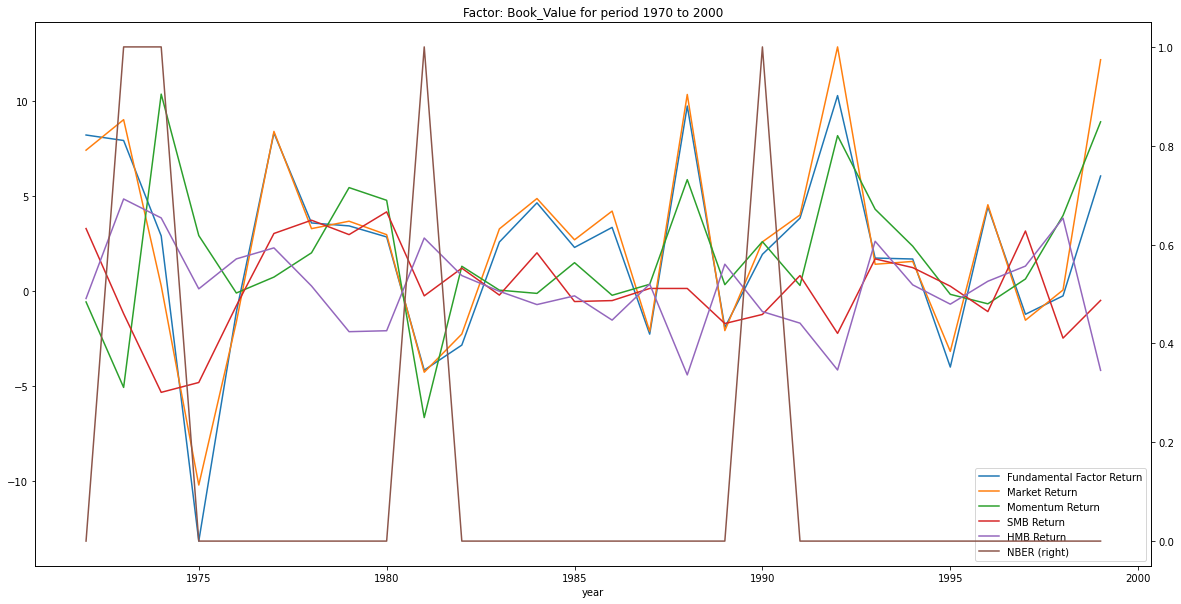

Parameters for factor: Book_Value for period 2001 to 2020 :

Excess Return: -0.2836661243804204
Volatility: 0.05124041018076211
Skewness: -1.3211443394270102
Kurtosis: 1.1092349404751984
Sharpe Ratio: 0.21589563846898796
Information Ratio: -0.7107897619327719



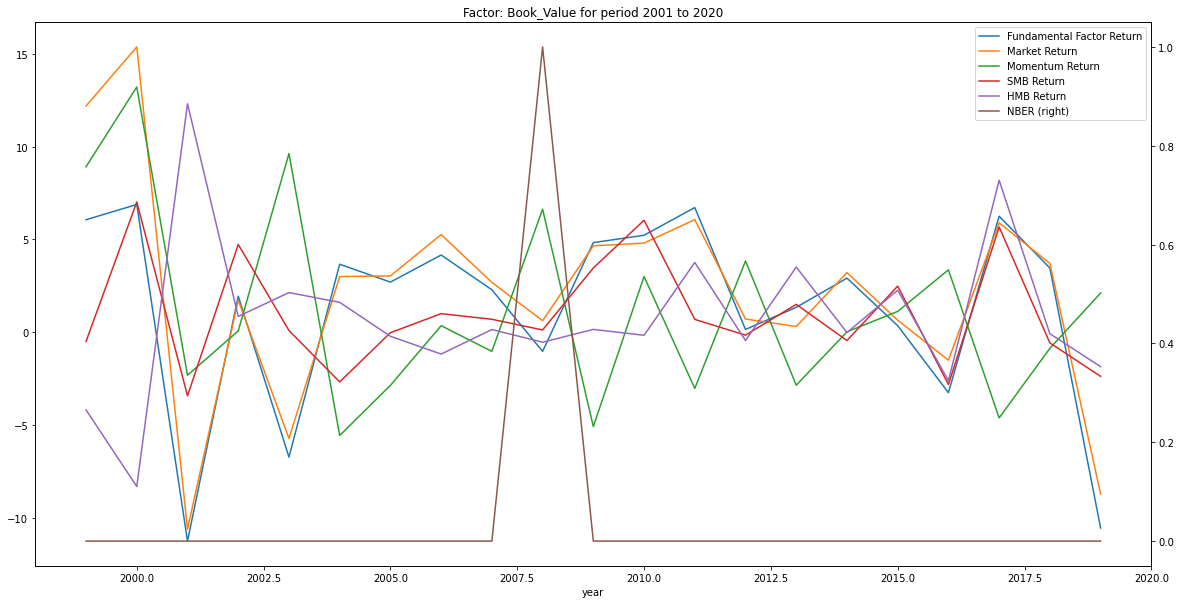

Parameters for factor: Trailing_Cash_Flow for period 1970 to 2020 :

Excess Return: 0.4329194889696377
Volatility: 0.07164785590294535
Skewness: -0.3898561563527057
Kurtosis: 1.434814945119931
Sharpe Ratio: 0.3468944884946996
Information Ratio: 0.20707148768247433



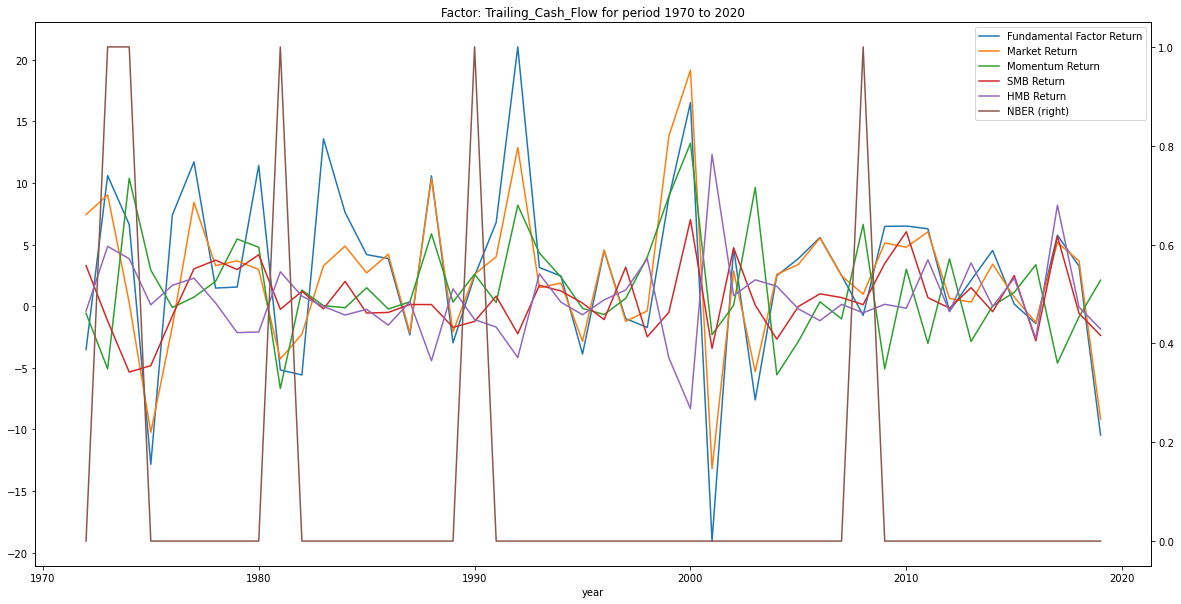

Parameters for factor: Trailing_Cash_Flow for period 1970 to 2000 :

Excess Return: 0.5080394536401931
Volatility: 0.07030767144923472
Skewness: 0.09688502508976532
Kurtosis: 0.3794861194337322
Sharpe Ratio: 0.47738937700682493
Information Ratio: 0.33324836070232344



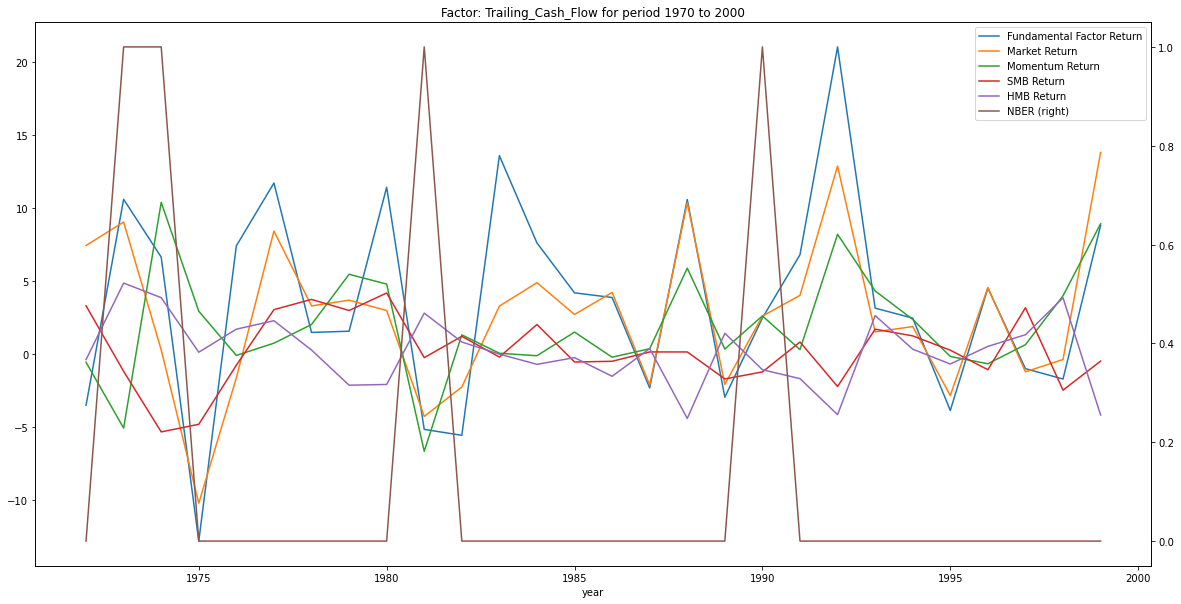

Parameters for factor: Trailing_Cash_Flow for period 2001 to 2020 :

Excess Return: -0.19002707201680558
Volatility: 0.07175113576279675
Skewness: -1.130198969623112
Kurtosis: 2.8338067115762198
Sharpe Ratio: 0.22640844887635933
Information Ratio: -0.4983557218063306



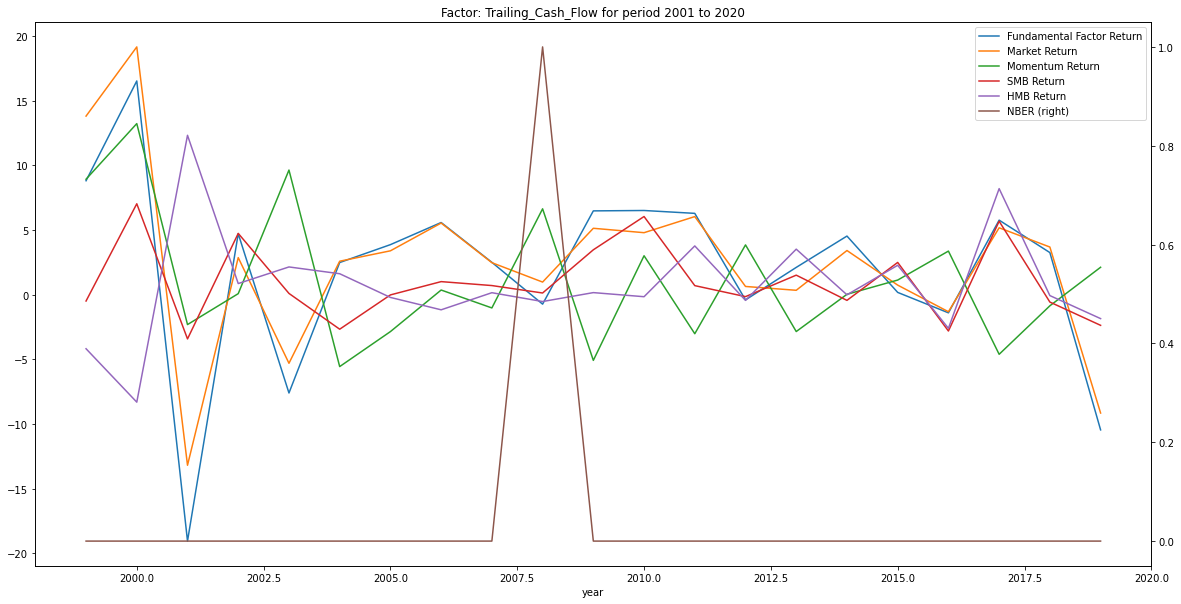

Parameters for factor: Trailing_Gross_Sales for period 1970 to 2020 :

Excess Return: -0.3195108556339048
Volatility: 0.048517933790955876
Skewness: -0.5964805774235341
Kurtosis: 0.8250304565088991
Sharpe Ratio: 0.3713128422484915
Information Ratio: -0.3554444672700595



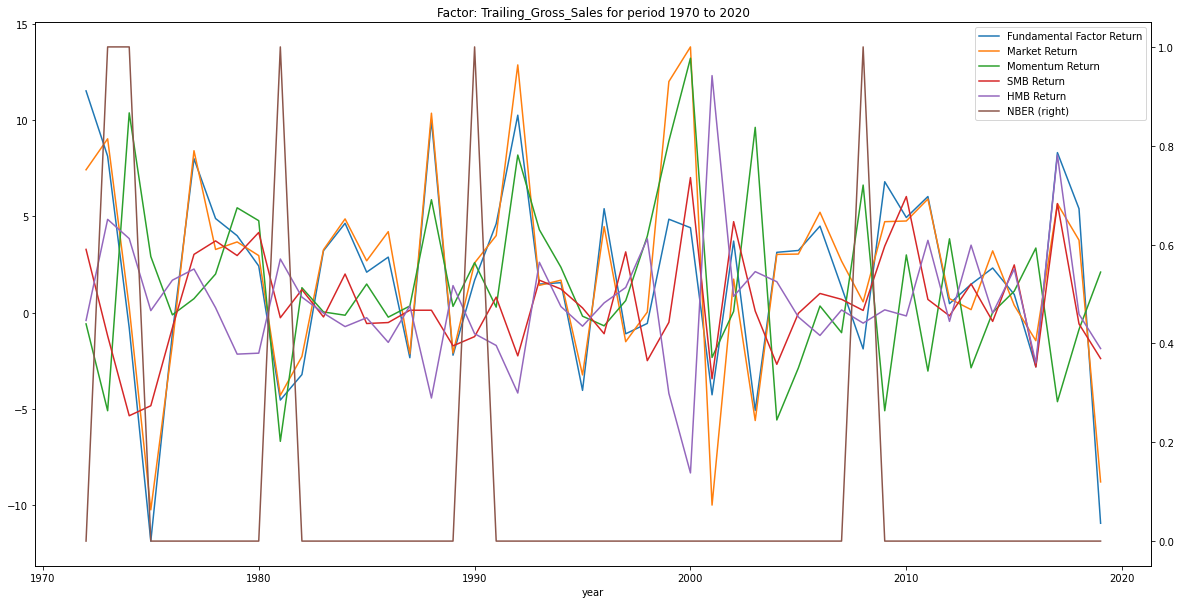

Parameters for factor: Trailing_Gross_Sales for period 1970 to 2000 :

Excess Return: -0.2199694882380152
Volatility: 0.05047384228642587
Skewness: -0.39420396551879083
Kurtosis: 0.7804271868359836
Sharpe Ratio: 0.3996888795879214
Information Ratio: -0.5099199077951774



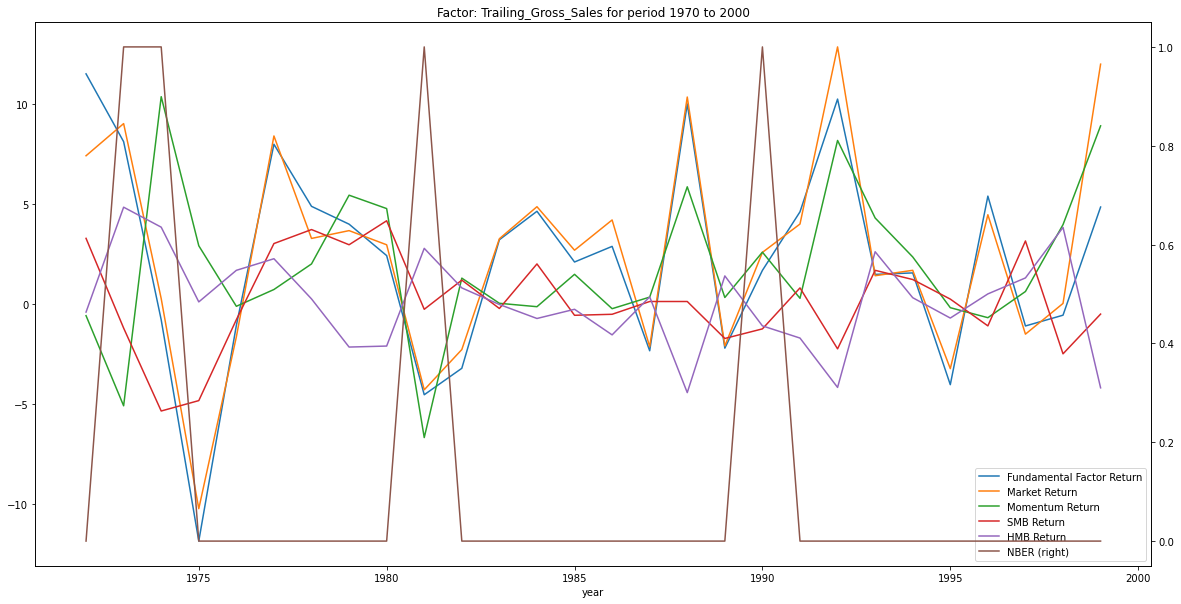

Parameters for factor: Trailing_Gross_Sales for period 2001 to 2020 :

Excess Return: -0.10951639534179947
Volatility: 0.044895094500072695
Skewness: -1.1792981403763694
Kurtosis: 1.5285605610477204
Sharpe Ratio: 0.3691970325091565
Information Ratio: -0.17648556701090817



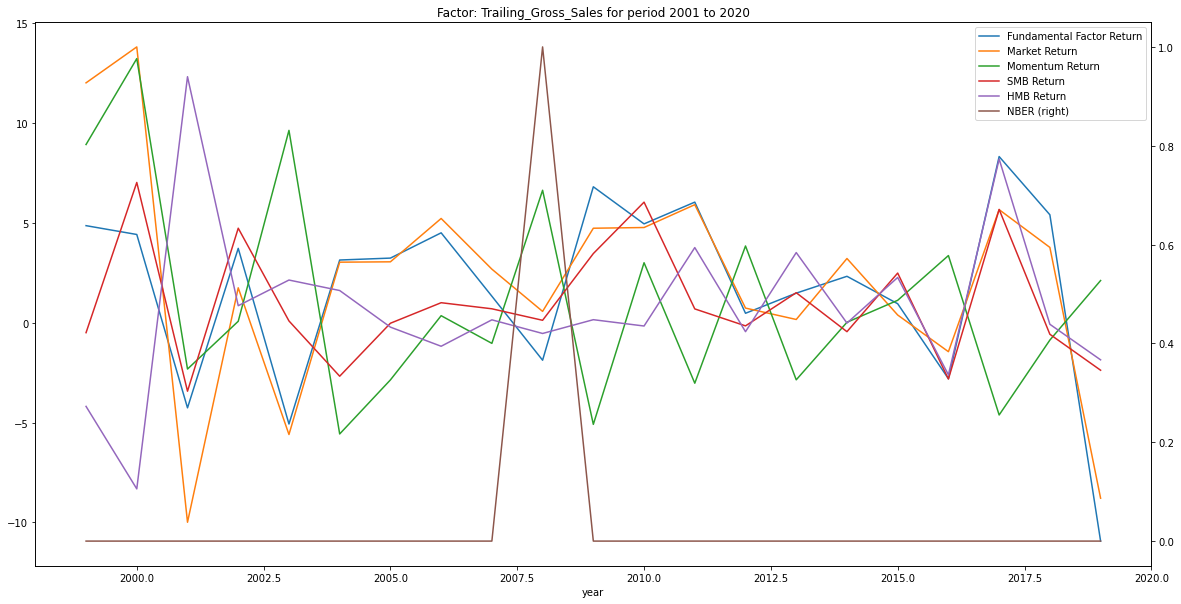

Parameters for factor: Trailing_Gross_Revenue for period 1970 to 2020 :

Excess Return: -0.3195108556339048
Volatility: 0.048517933790955876
Skewness: -0.5964805774235341
Kurtosis: 0.8250304565088991
Sharpe Ratio: 0.3713128422484915
Information Ratio: -0.3554444672700595



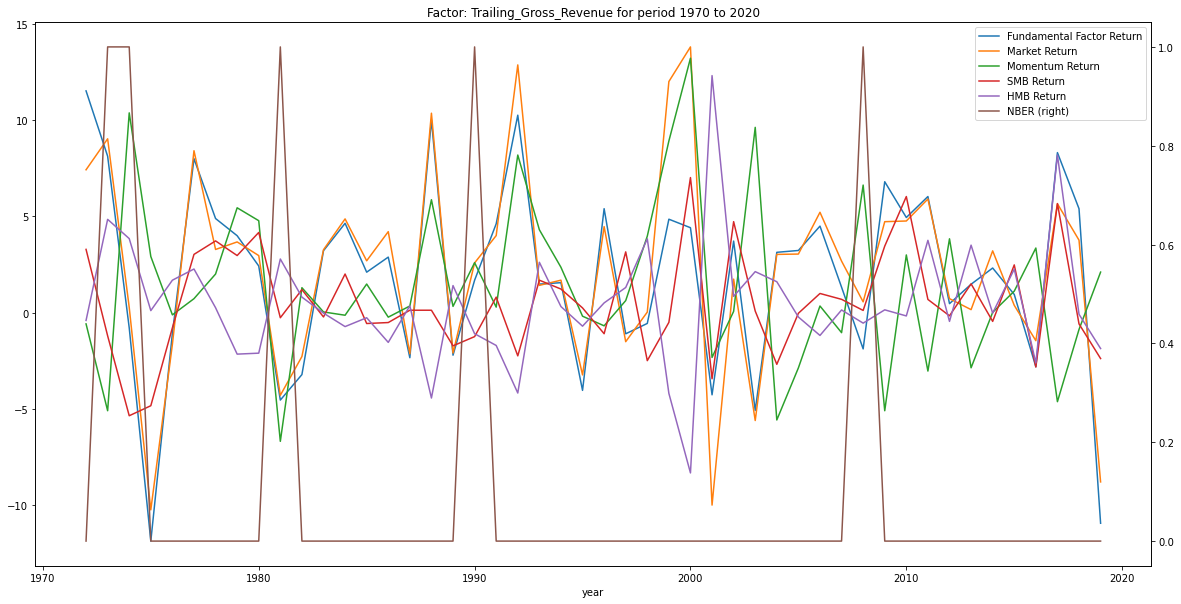

Parameters for factor: Trailing_Gross_Revenue for period 1970 to 2000 :

Excess Return: -0.2199694882380152
Volatility: 0.05047384228642587
Skewness: -0.39420396551879083
Kurtosis: 0.7804271868359836
Sharpe Ratio: 0.3996888795879214
Information Ratio: -0.5099199077951774



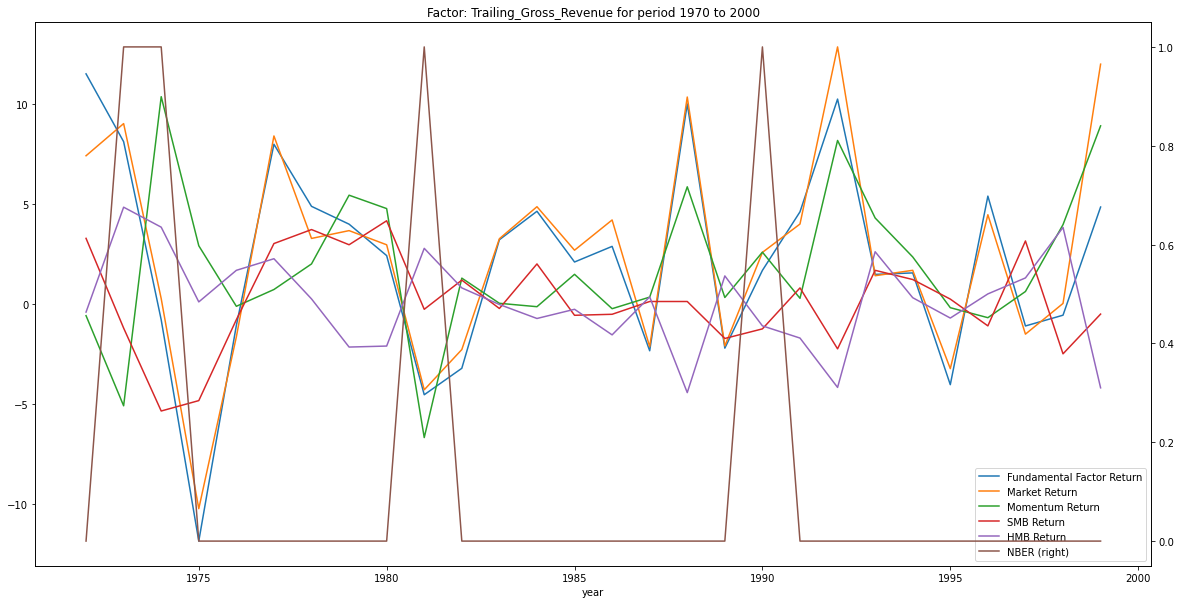

Parameters for factor: Trailing_Gross_Revenue for period 2001 to 2020 :

Excess Return: -0.10951639534179947
Volatility: 0.044895094500072695
Skewness: -1.1792981403763694
Kurtosis: 1.5285605610477204
Sharpe Ratio: 0.3691970325091565
Information Ratio: -0.17648556701090817



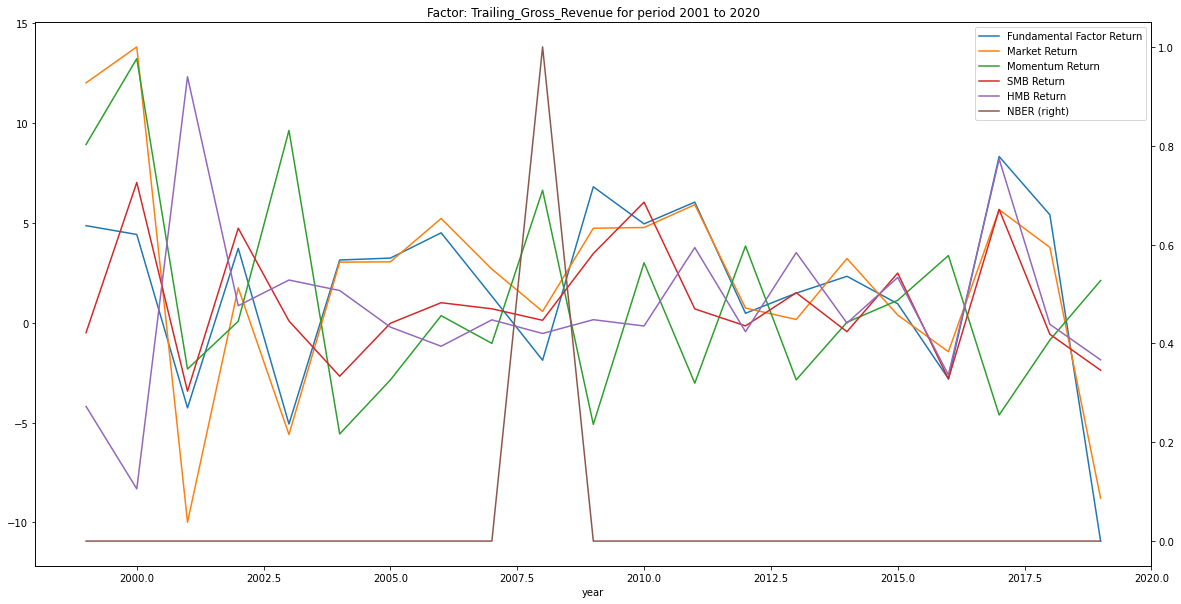

Parameters for factor: Trailing_Gross_Dividends for period 1970 to 2020 :

Excess Return: -0.5515874997275336
Volatility: 0.043762938737385626
Skewness: -0.8452920155532146
Kurtosis: 2.0067535778074346
Sharpe Ratio: 0.36221308502724875
Information Ratio: -0.7670951098958853



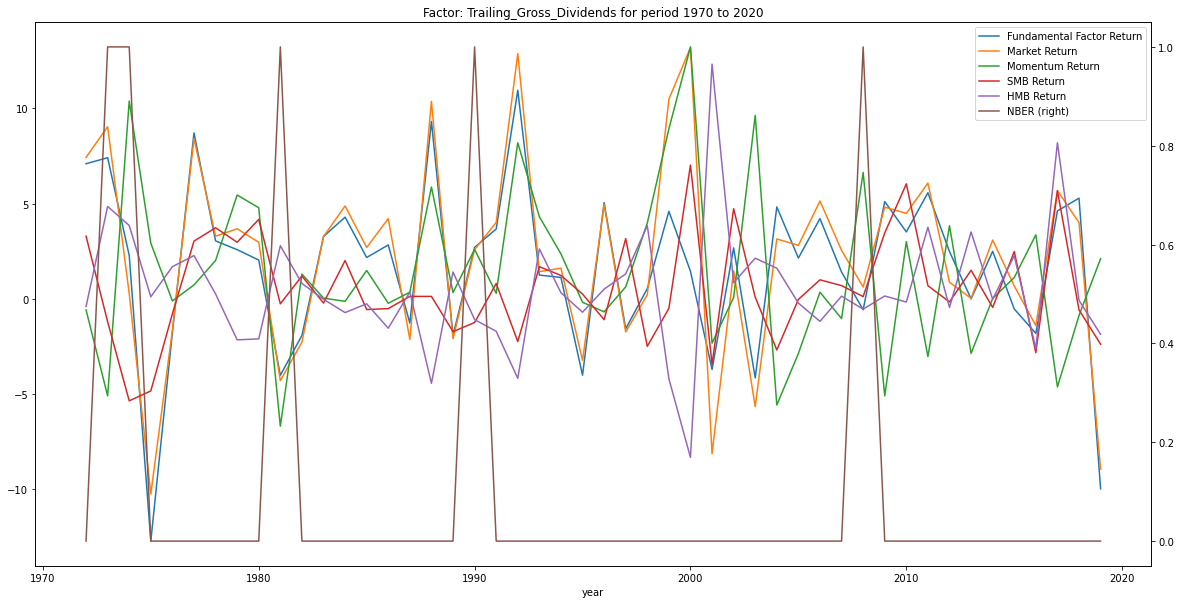

Parameters for factor: Trailing_Gross_Dividends for period 1970 to 2000 :

Excess Return: -0.26531634212048205
Volatility: 0.04714036270660099
Skewness: -0.7534537861054948
Kurtosis: 2.1468251437294414
Sharpe Ratio: 0.39830277128025005
Information Ratio: -0.8131333633281356



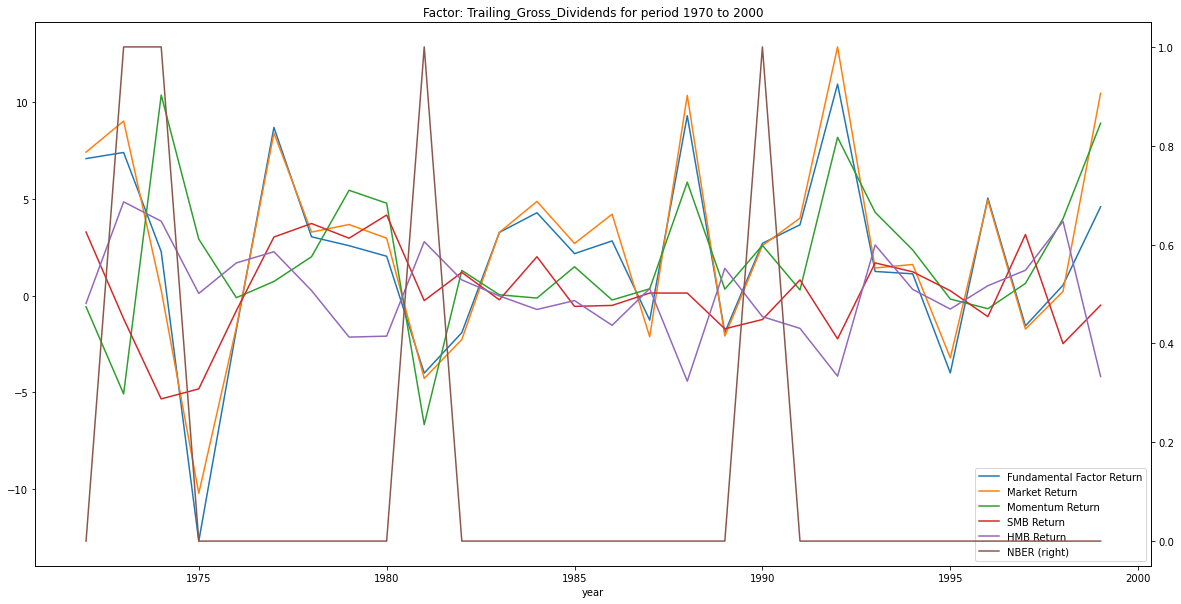

Parameters for factor: Trailing_Gross_Dividends for period 2001 to 2020 :

Excess Return: -0.19692889639515143
Volatility: 0.03788212285528722
Skewness: -1.4248826082129078
Kurtosis: 2.3447405833207937
Sharpe Ratio: 0.3530106394529534
Information Ratio: -0.33583200039644306



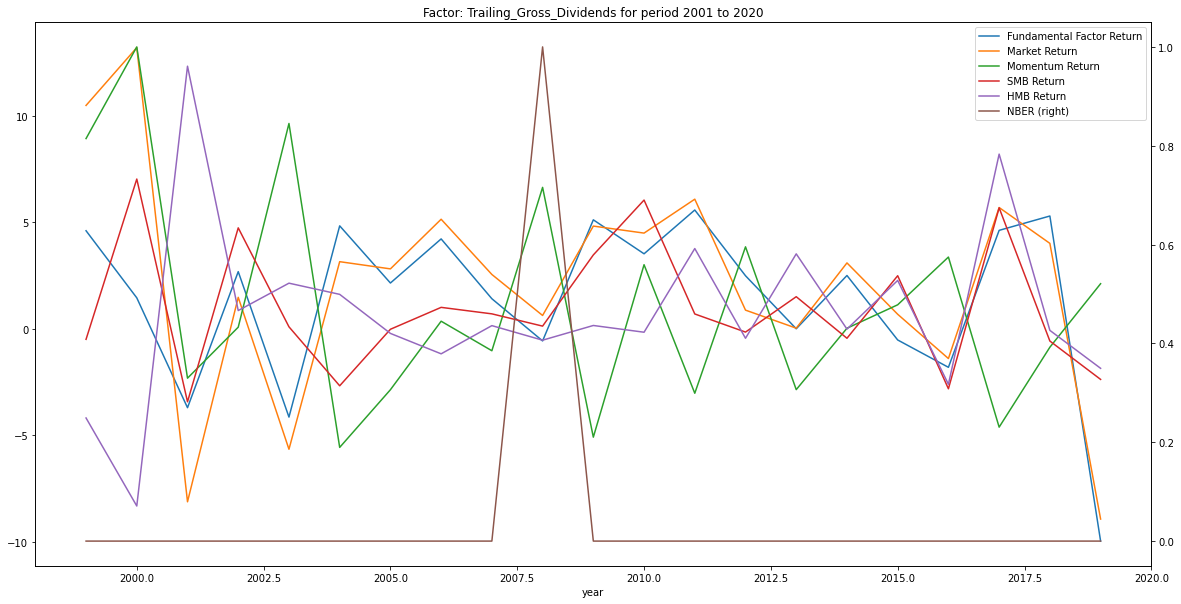

Parameters for factor: Trailing_Gross_Investments for period 1970 to 2020 :

Excess Return: -0.6253545136487038
Volatility: 0.051554215827540995
Skewness: -0.78501305072098
Kurtosis: 1.0844133186659635
Sharpe Ratio: 0.30450828152837073
Information Ratio: -1.0867720292423761



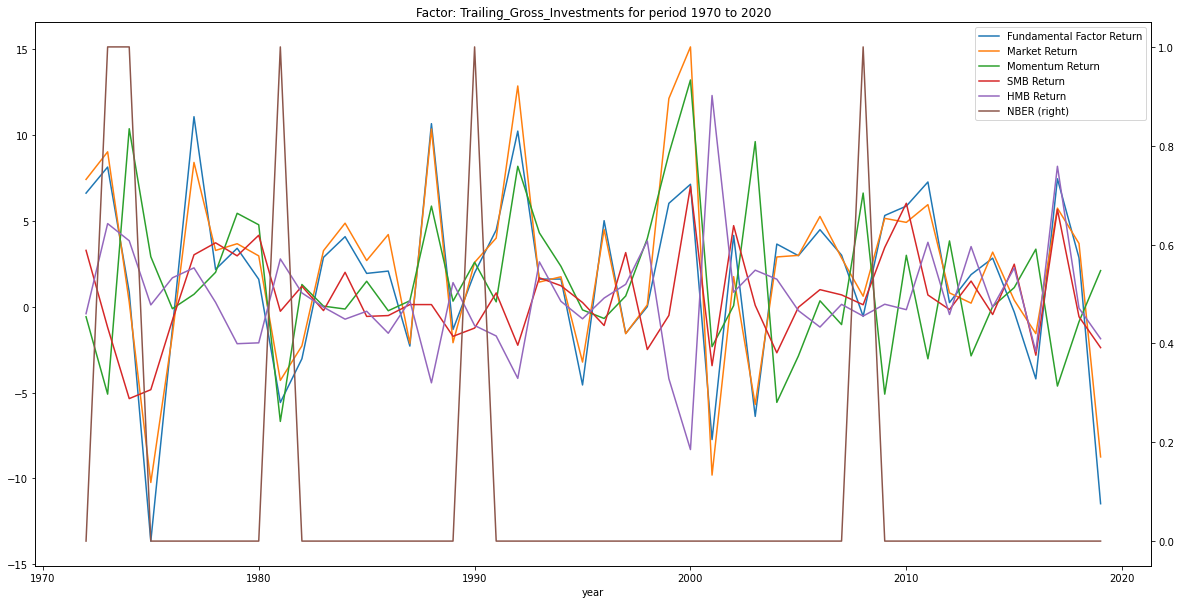

Parameters for factor: Trailing_Gross_Investments for period 1970 to 2000 :

Excess Return: -0.34065076895594526
Volatility: 0.051838721136667605
Skewness: -0.6114545890864556
Kurtosis: 1.7016479958811344
Sharpe Ratio: 0.34116202354937025
Information Ratio: -0.9583646334737528



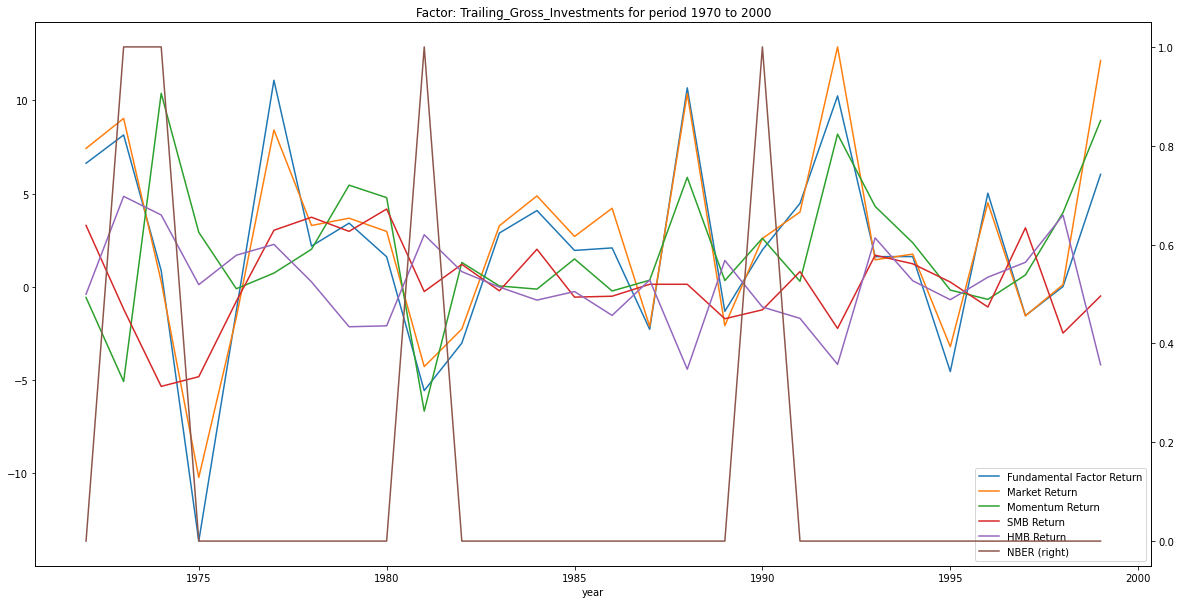

Parameters for factor: Trailing_Gross_Investments for period 2001 to 2020 :

Excess Return: -0.18402688235851827
Volatility: 0.0507499333139144
Skewness: -1.1856643564035327
Kurtosis: 0.8154119036948688
Sharpe Ratio: 0.2981601643914213
Information Ratio: -0.3868187966448701



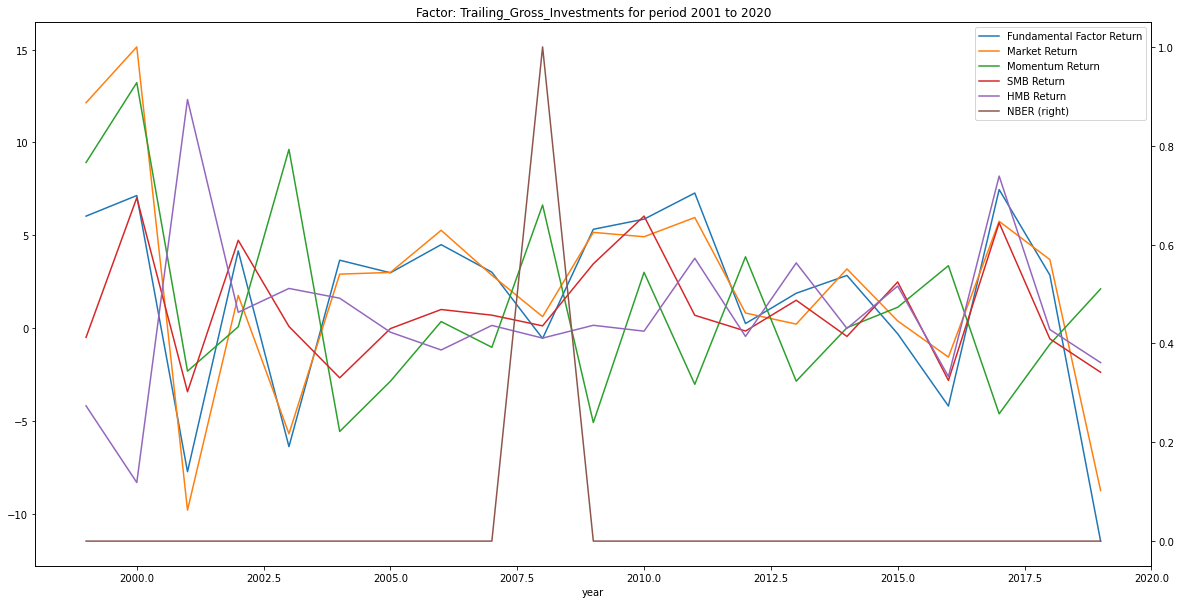

Parameters for factor: Trailing_ROA for period 1970 to 2020 :

Excess Return: 0.5023398597856188
Volatility: 0.05283106885303722
Skewness: -0.48483233231696066
Kurtosis: 0.146289978950509
Sharpe Ratio: 0.4670120136945429
Information Ratio: 0.4018993257470589



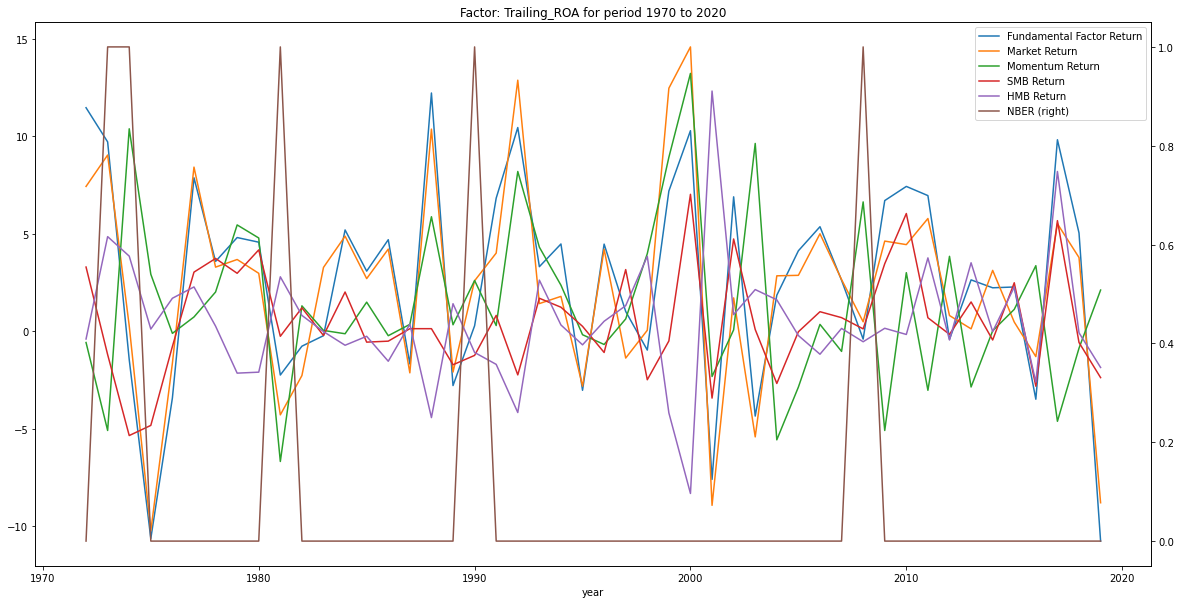

Parameters for factor: Trailing_ROA for period 1970 to 2000 :

Excess Return: 0.09601482832959385
Volatility: 0.051667176276634676
Skewness: -0.23510923251240826
Kurtosis: 0.16867002422246724
Sharpe Ratio: 0.5133211904406143
Information Ratio: 0.16234483733908192



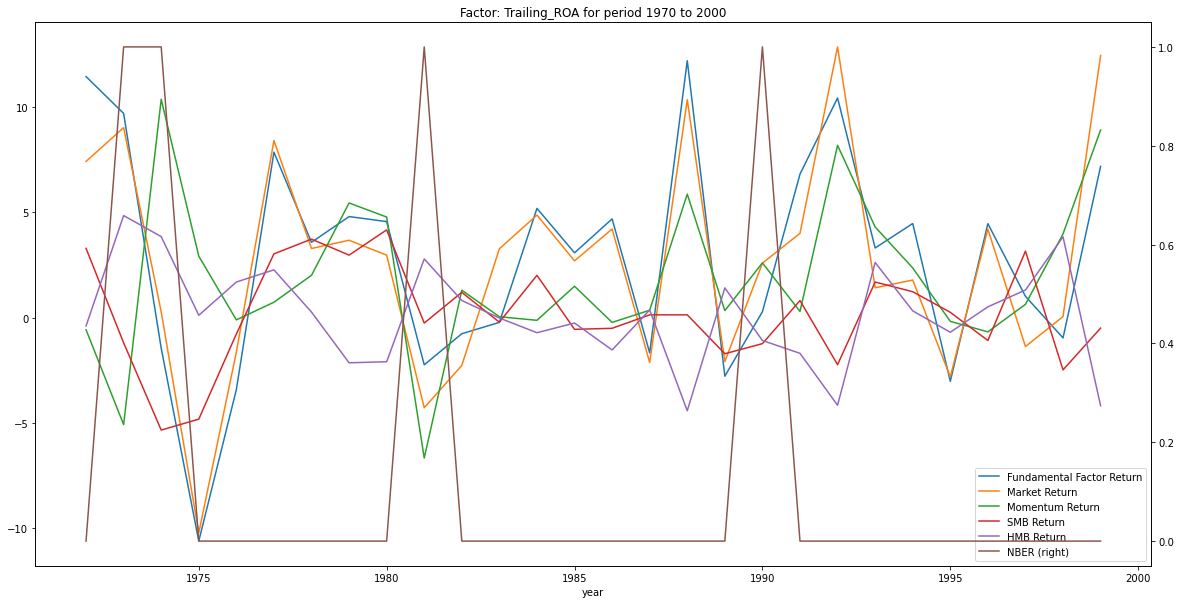

Parameters for factor: Trailing_ROA for period 2001 to 2020 :

Excess Return: 0.11879225195290899
Volatility: 0.05400205708369737
Skewness: -0.8913629356834164
Kurtosis: 0.4318748491451494
Sharpe Ratio: 0.4519881670063556
Information Ratio: 0.2137834725567478



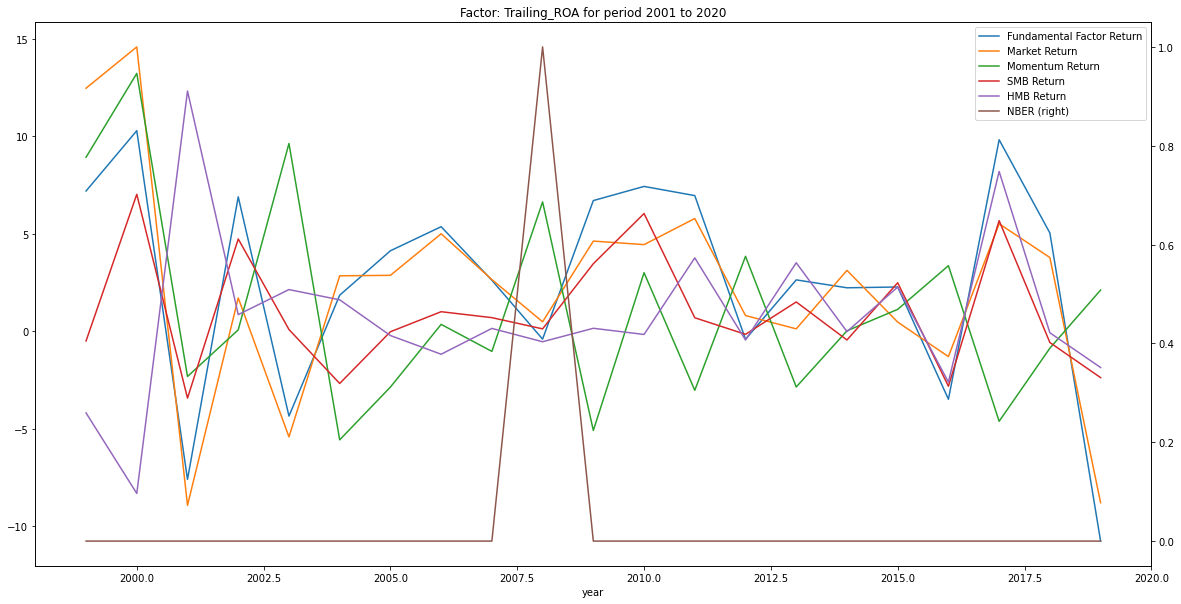

Parameters for factor: Asset_Turnover for period 1970 to 2020 :

Excess Return: 1.0542078777435924
Volatility: 0.05592149542252493
Skewness: -0.5171700270161358
Kurtosis: 0.08088153469837689
Sharpe Ratio: 0.5179266556038922
Information Ratio: 0.6648533868495956



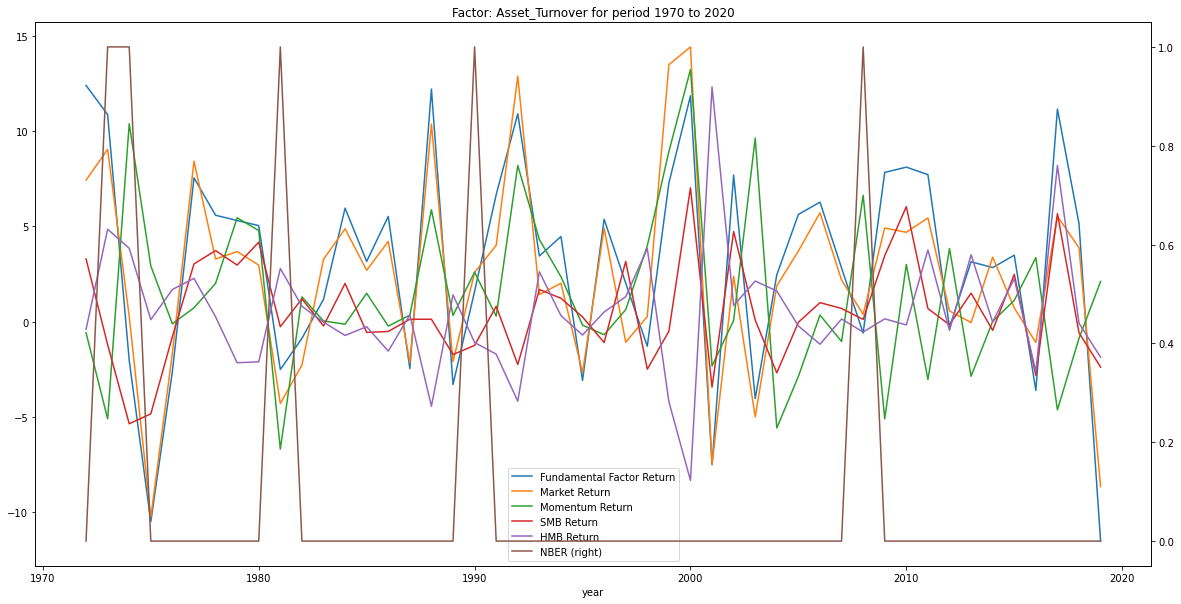

Parameters for factor: Asset_Turnover for period 1970 to 2000 :

Excess Return: 0.2509688962375063
Volatility: 0.05353897420280047
Skewness: -0.27896531100447236
Kurtosis: 0.003262321355111286
Sharpe Ratio: 0.5598636571152762
Information Ratio: 0.36924490677263205



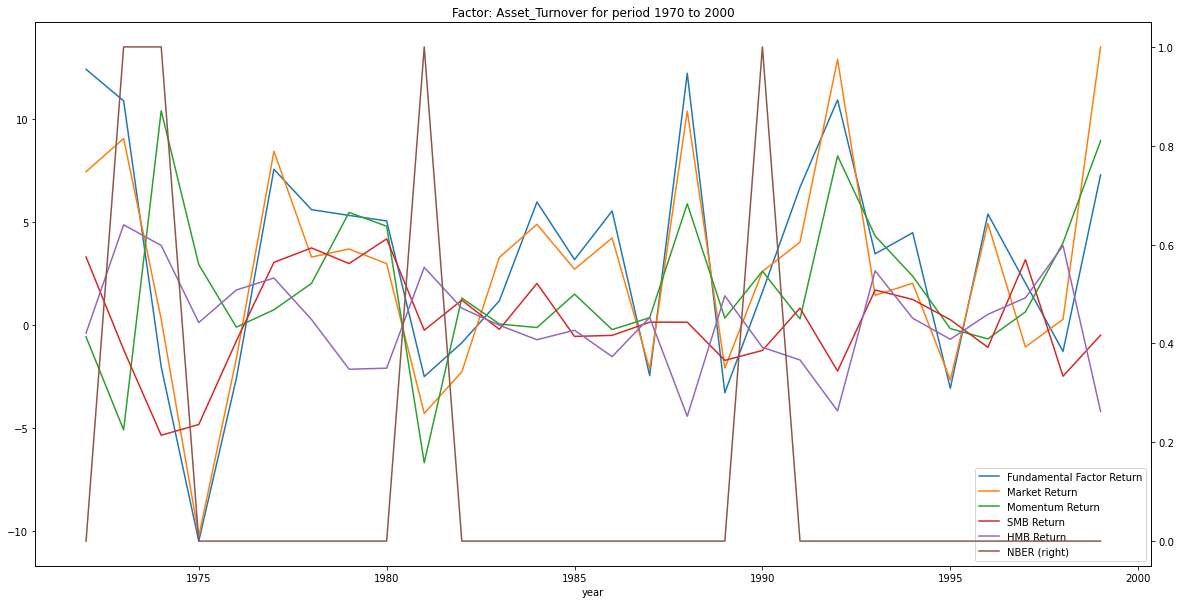

Parameters for factor: Asset_Turnover for period 2001 to 2020 :

Excess Return: 0.23994190786606961
Volatility: 0.05838663239201341
Skewness: -0.8741950350844524
Kurtosis: 0.4959278520714361
Sharpe Ratio: 0.507906367565863
Information Ratio: 0.3714490533939107



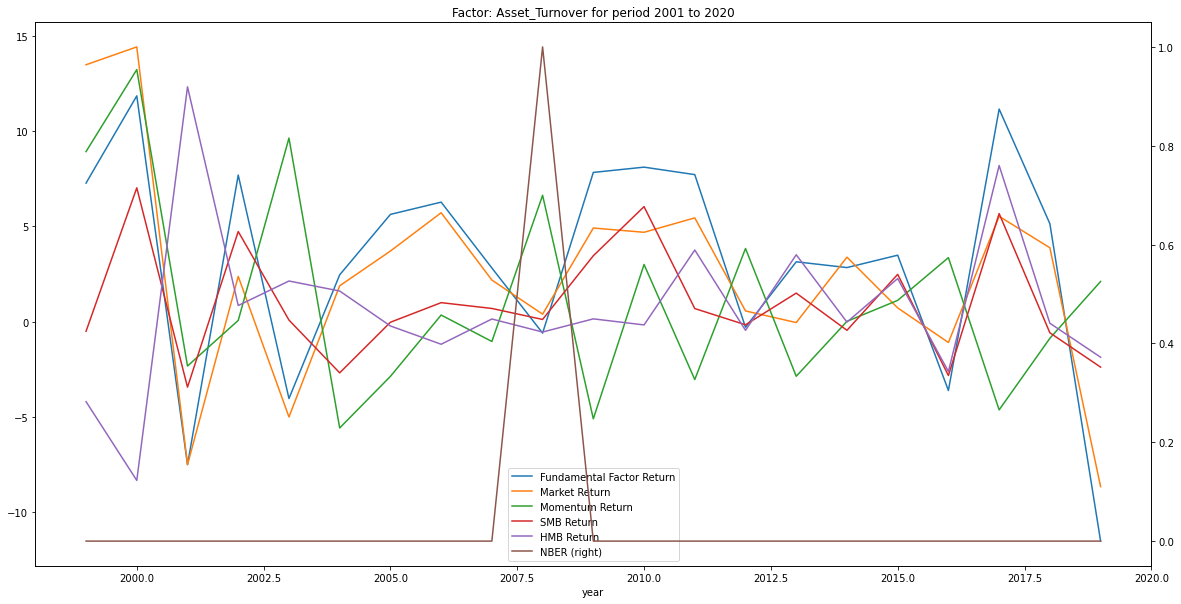

Parameters for factor: Altman Z Score for period 1970 to 2020 :

Excess Return: 2.876299076714999
Volatility: 0.0830167241090774
Skewness: 0.8504997907028637
Kurtosis: 6.300684669011491
Sharpe Ratio: 0.44396115479340376
Information Ratio: 0.7407161068730651



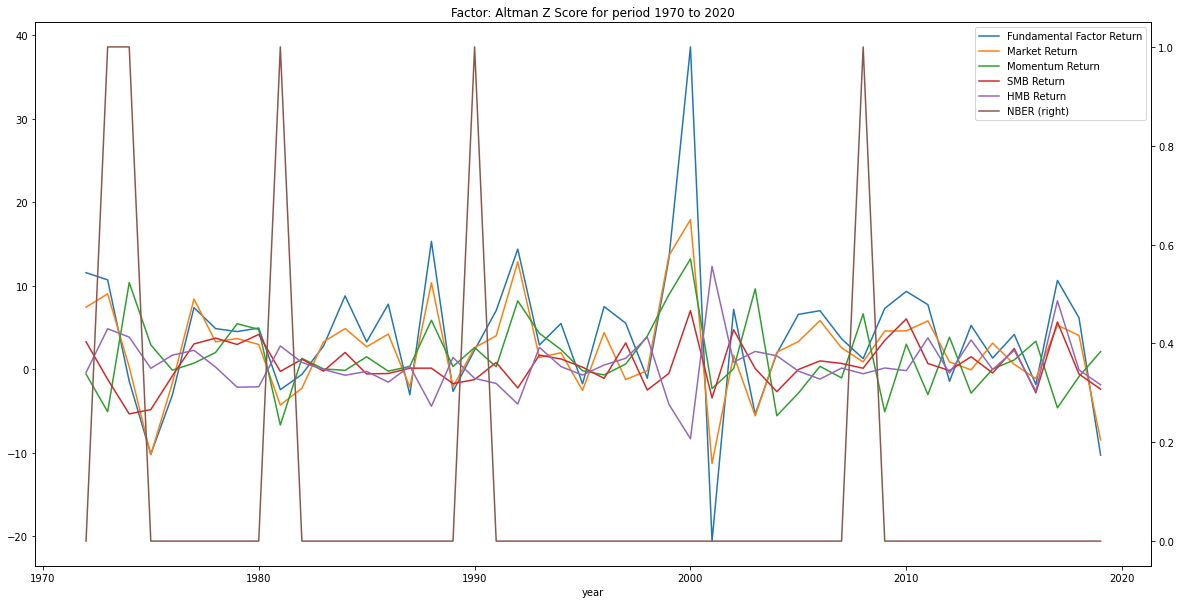

Parameters for factor: Altman Z Score for period 1970 to 2000 :

Excess Return: 0.8991619200108767
Volatility: 0.05982444693404602
Skewness: -0.09683731205050555
Kurtosis: -0.2073474836222995
Sharpe Ratio: 0.6513762753255633
Information Ratio: 1.1123617353226007



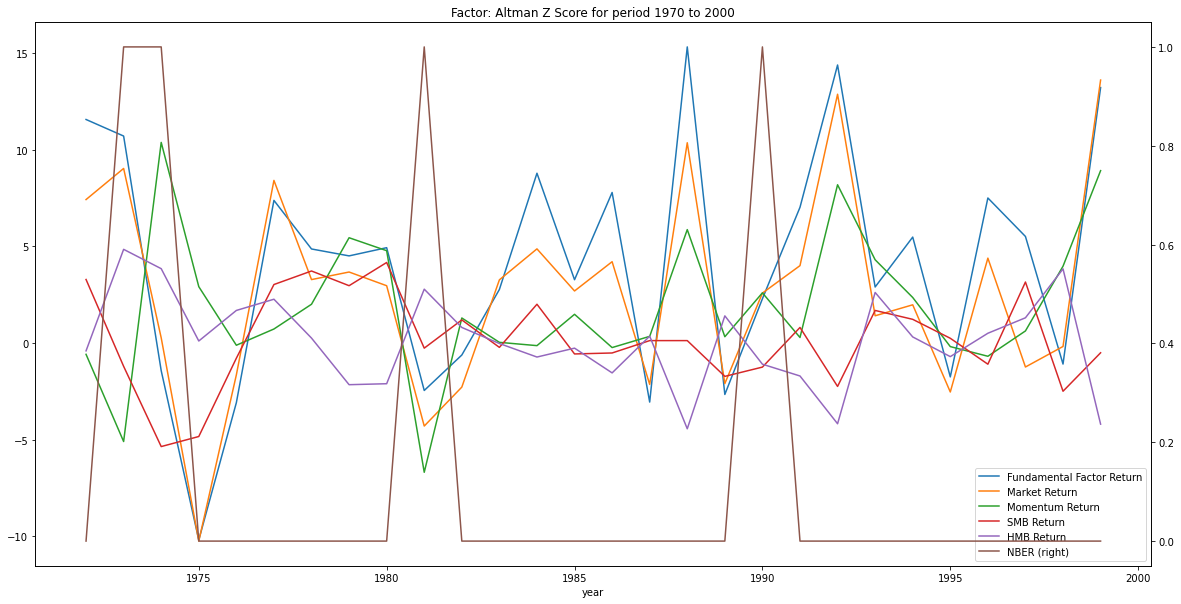

Parameters for factor: Altman Z Score for period 2001 to 2020 :

Excess Return: 0.6257257360892439
Volatility: 0.10663464178222858
Skewness: 0.8980813673651811
Kurtosis: 5.153713902707169
Sharpe Ratio: 0.35997575985970687
Information Ratio: 0.43952538681535236



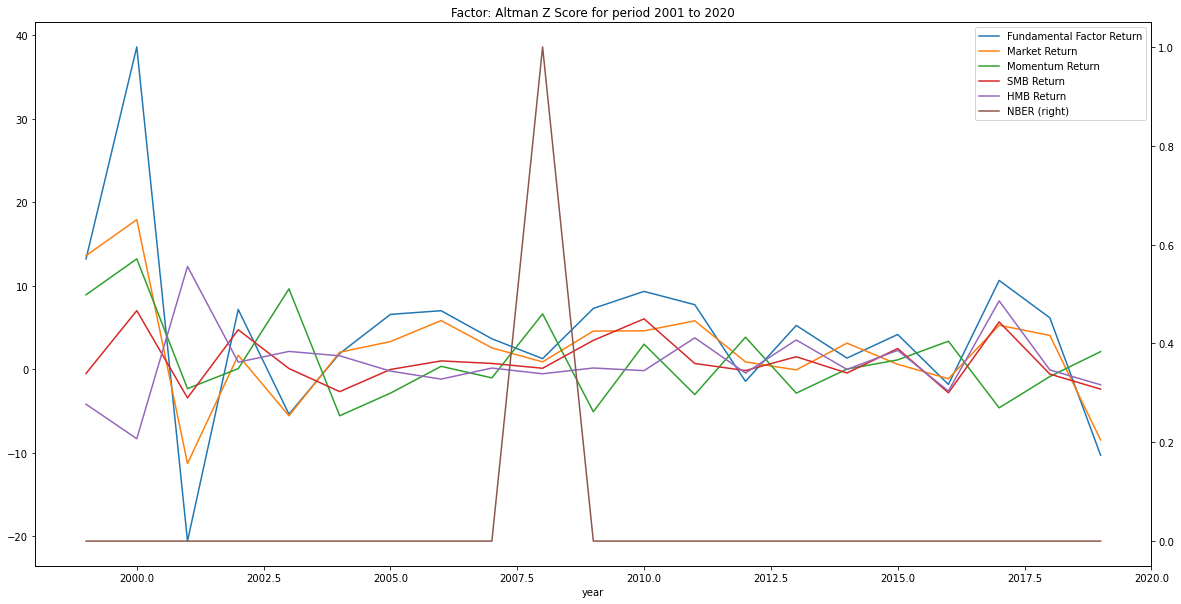

Parameters for factor: O Score for period 1970 to 2020 :

Excess Return: -1.4300606204558477
Volatility: 0.13617527793385026
Skewness: -1.7965112144927127
Kurtosis: 8.352448676855307
Sharpe Ratio: 0.046219969570124635
Information Ratio: (-0.1672950334349953+0.5504861474312054j)



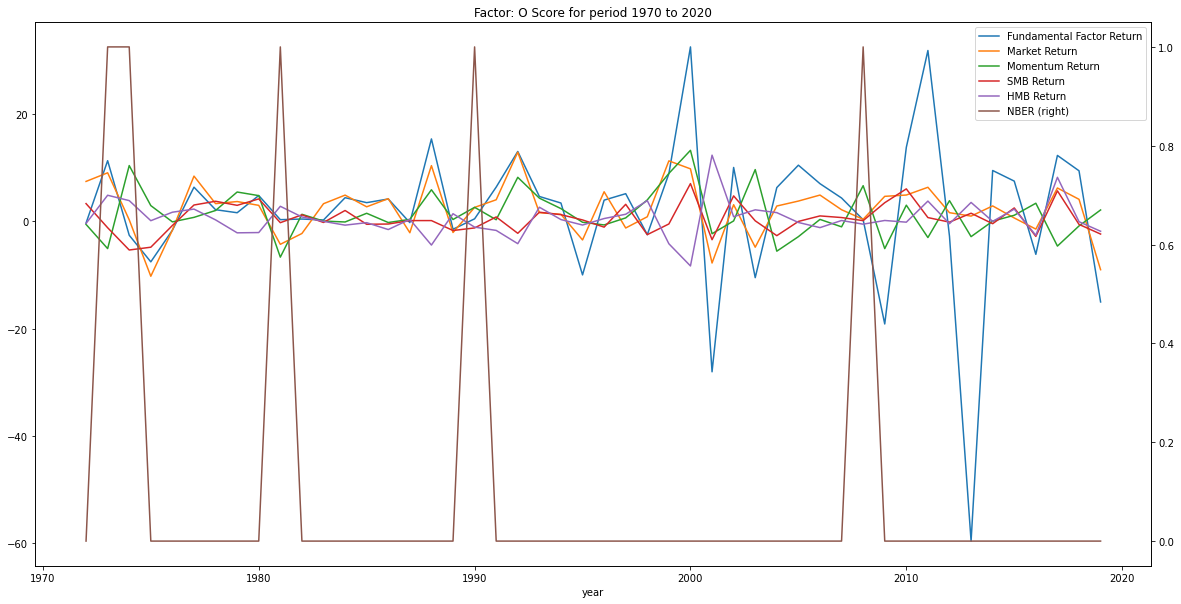

Parameters for factor: O Score for period 1970 to 2000 :

Excess Return: 0.0073339831992260685
Volatility: 0.054292527616231545
Skewness: 0.14076341236806808
Kurtosis: 0.7793914302862275
Sharpe Ratio: 0.4598316499608788
Information Ratio: 0.008149959257031086



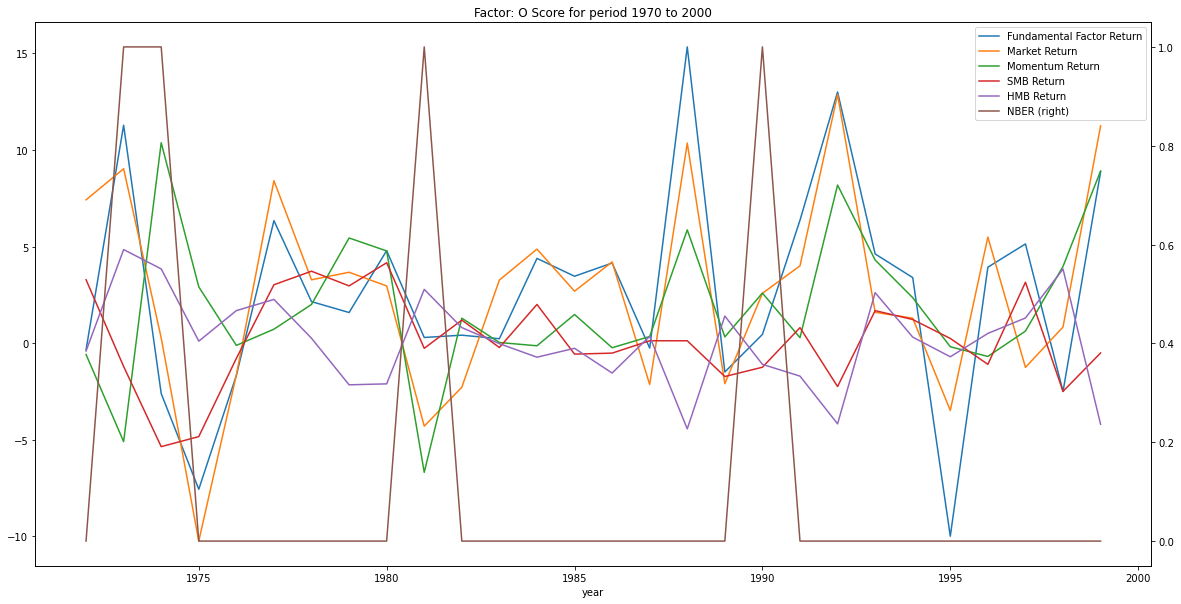

Parameters for factor: O Score for period 2001 to 2020 :

Excess Return: -0.8195524396309177
Volatility: 0.19633573738190882
Skewness: -1.3234429824529448
Kurtosis: 3.2713340561280586
Sharpe Ratio: -0.0732744853562973
Information Ratio: -0.4542243086703435



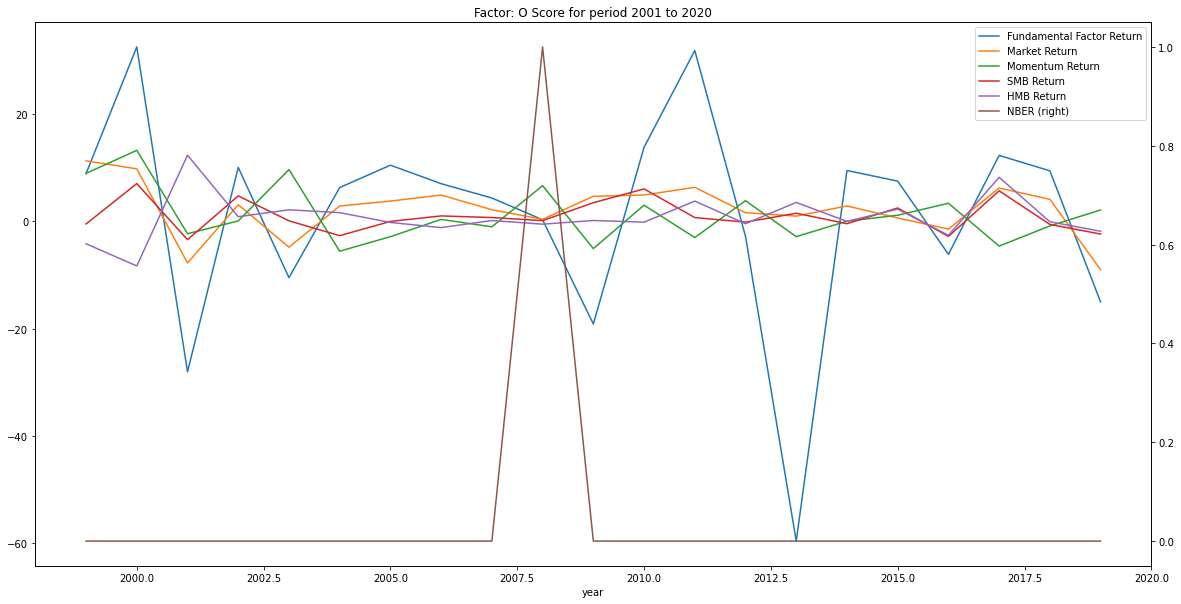

In [80]:
for factor in factor_list:
    frame_list.append(calculate_fundamental_index_params(index_sample,factor,start1,end1))
    frame_list.append(calculate_fundamental_index_params(index_sample,factor,start2,end2))
    frame_list.append(calculate_fundamental_index_params(index_sample,factor,start3,end3))

## Creating Market Indexes (Part 5)

In [81]:
idio_data_annual_sample=idio_data_annual.loc[idio_data_annual['year']>1968]

In [82]:
idio_data_annual_sample['Market_Cap']=idio_data_annual_sample['SHROUT'].abs()*idio_data_annual_sample['PRC'].abs()

In [83]:
factor_list2=['Beta','Total_Vol_a','Alt_Total_Vol_a','Idio_CAPM_Vol_a','Idio_Fama3_Vol_a','Idio_Fama4_Vol_a']

start1=1969
end1=2020

start2=1969
end2=2000

start3=2000
end3=2020

Parameters for factor: Beta for period 1970 to 2020 :

Excess Return: 2.743009150960537
Volatility: 0.10182647445143297
Skewness: 0.50119688497219
Kurtosis: 4.810357872008844
Sharpe Ratio: 0.3852101348941506
Information Ratio: 0.7604938738521784



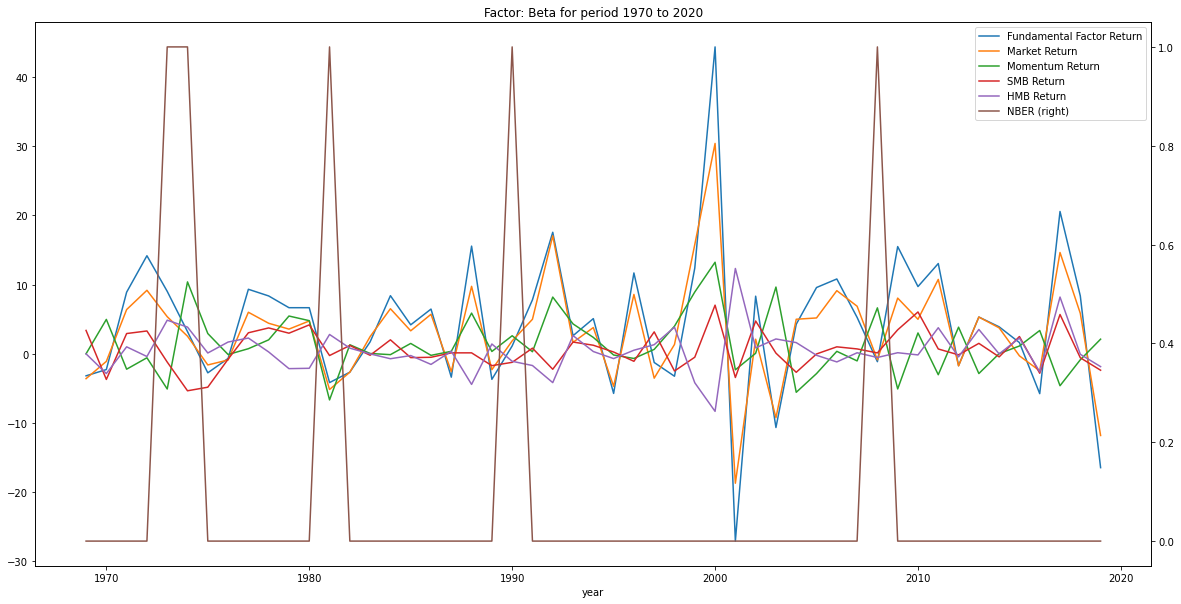

Parameters for factor: Beta for period 1970 to 2000 :

Excess Return: 0.8090508408564219
Volatility: 0.06411236087951815
Skewness: 0.272420818860032
Kurtosis: -0.9603842237734046
Sharpe Ratio: 0.6118095627577167
Information Ratio: 0.8512422829828394



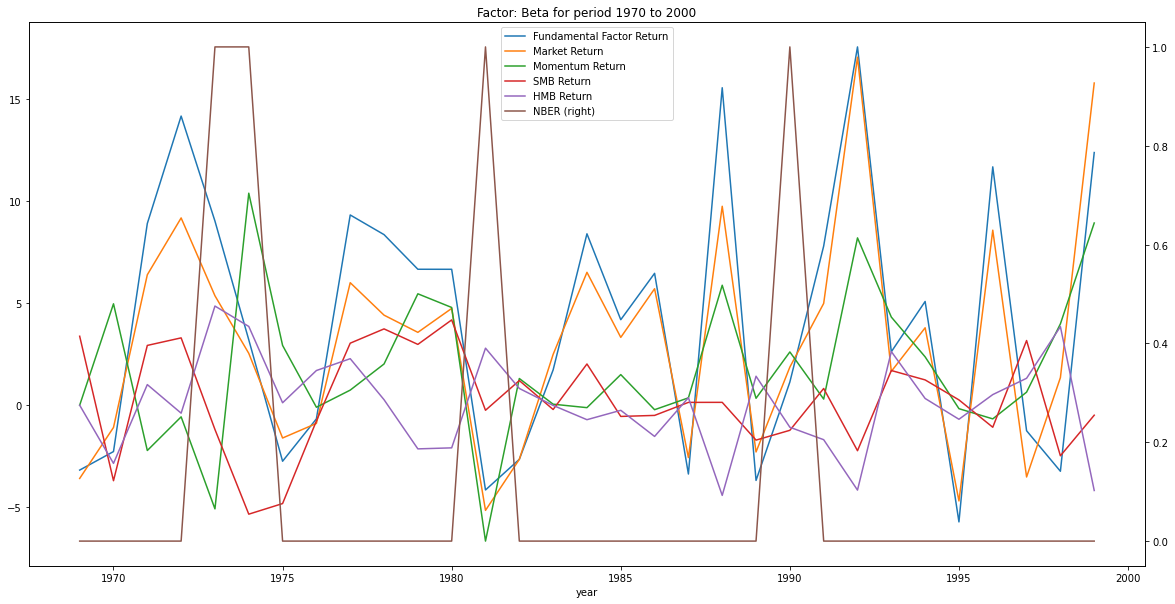

Parameters for factor: Beta for period 2001 to 2020 :

Excess Return: 0.39038046655807257
Volatility: 0.13904598554731434
Skewness: 0.3000539327762066
Kurtosis: 2.72029357130693
Sharpe Ratio: 0.30997255480431496
Information Ratio: 0.3356455047671067



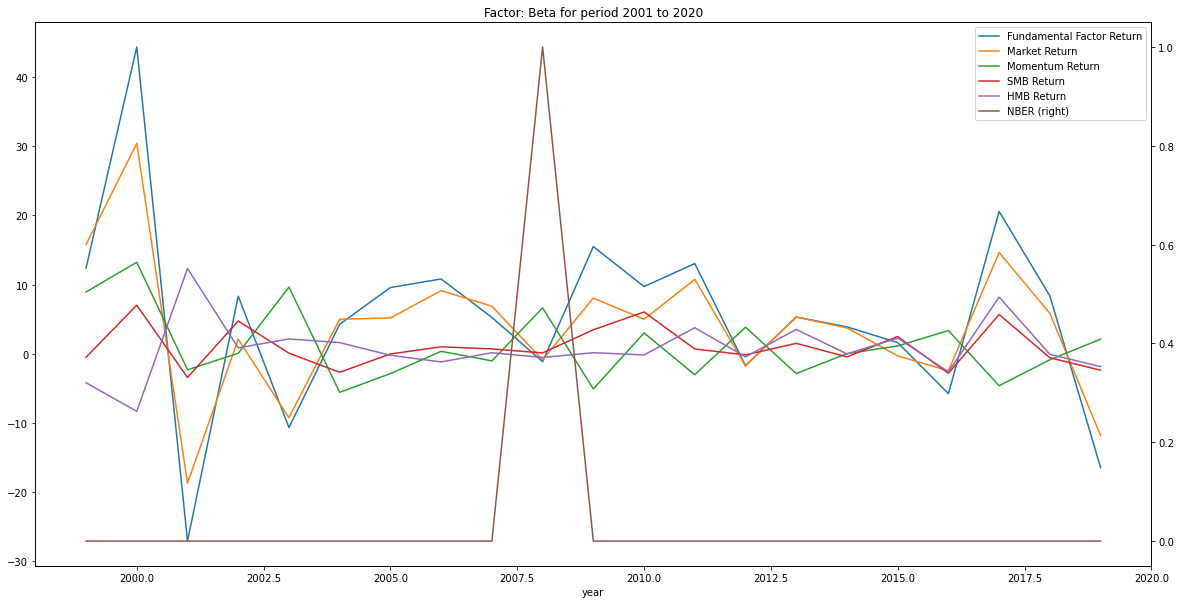

Parameters for factor: Total_Vol_a for period 1970 to 2020 :

Excess Return: 14.050743539578354
Volatility: 0.09558365888039409
Skewness: 2.9659740822718637
Kurtosis: 15.98461837815702
Sharpe Ratio: 0.6266634338061139
Information Ratio: 1.427550327799178



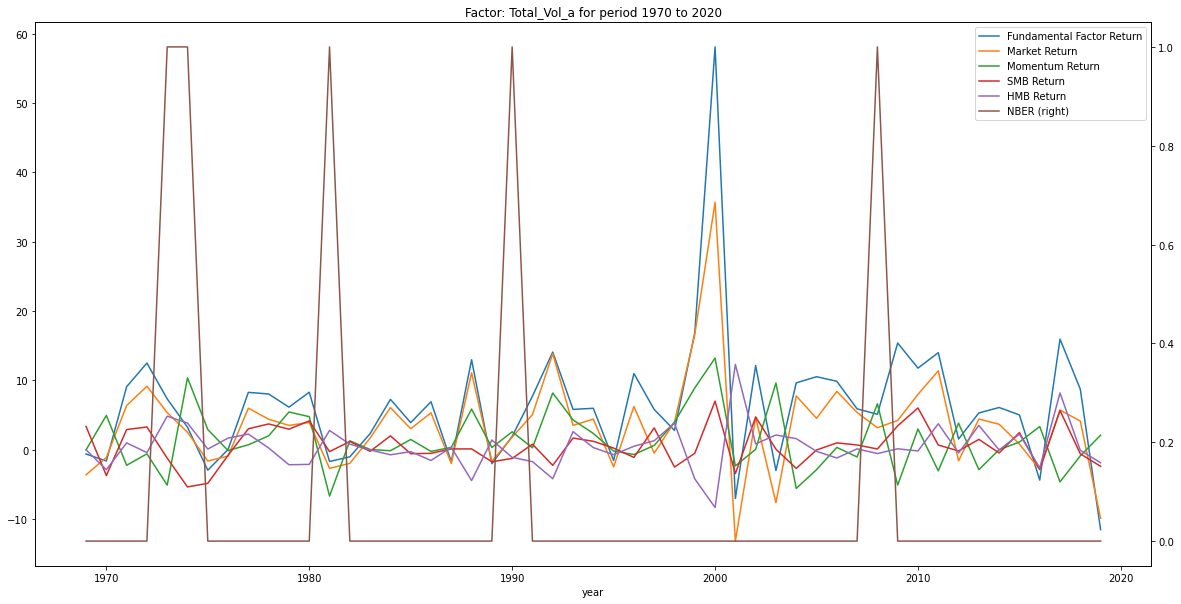

Parameters for factor: Total_Vol_a for period 1970 to 2000 :

Excess Return: 1.6462534570457756
Volatility: 0.052635508897873245
Skewness: 0.2719808622391134
Kurtosis: -0.6846703106128755
Sharpe Ratio: 0.9275797698524944
Information Ratio: 1.874060605252454



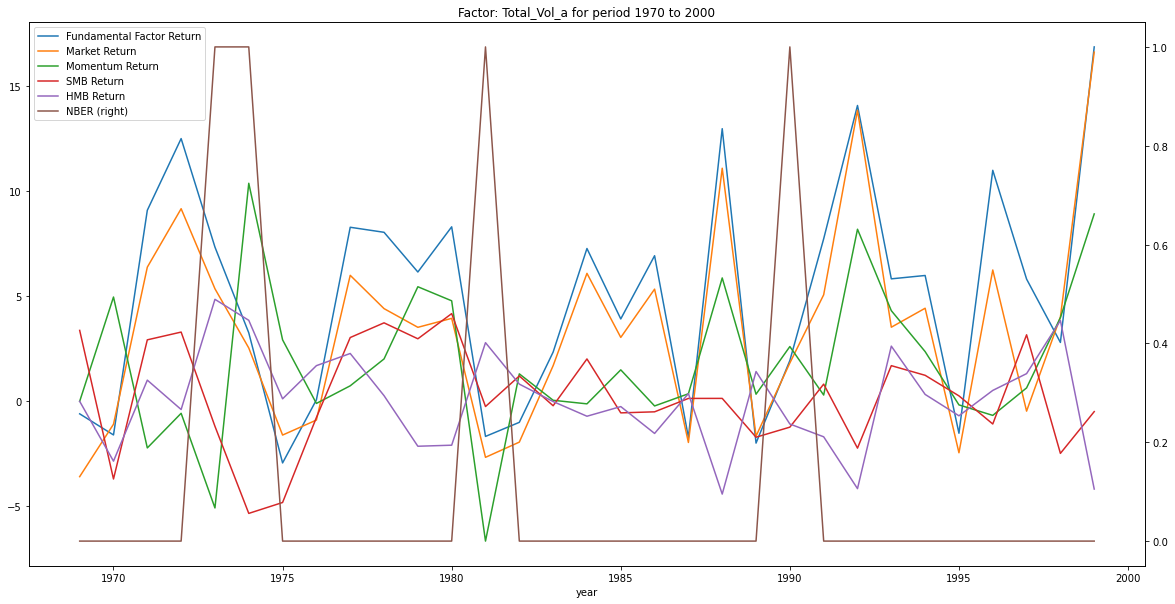

Parameters for factor: Total_Vol_a for period 2001 to 2020 :

Excess Return: 2.8887288943670457
Volatility: 0.1331534364291609
Skewness: 2.2518629700124655
Kurtosis: 8.50624563437568
Sharpe Ratio: 0.6119708141957375
Information Ratio: 1.2886667889151895



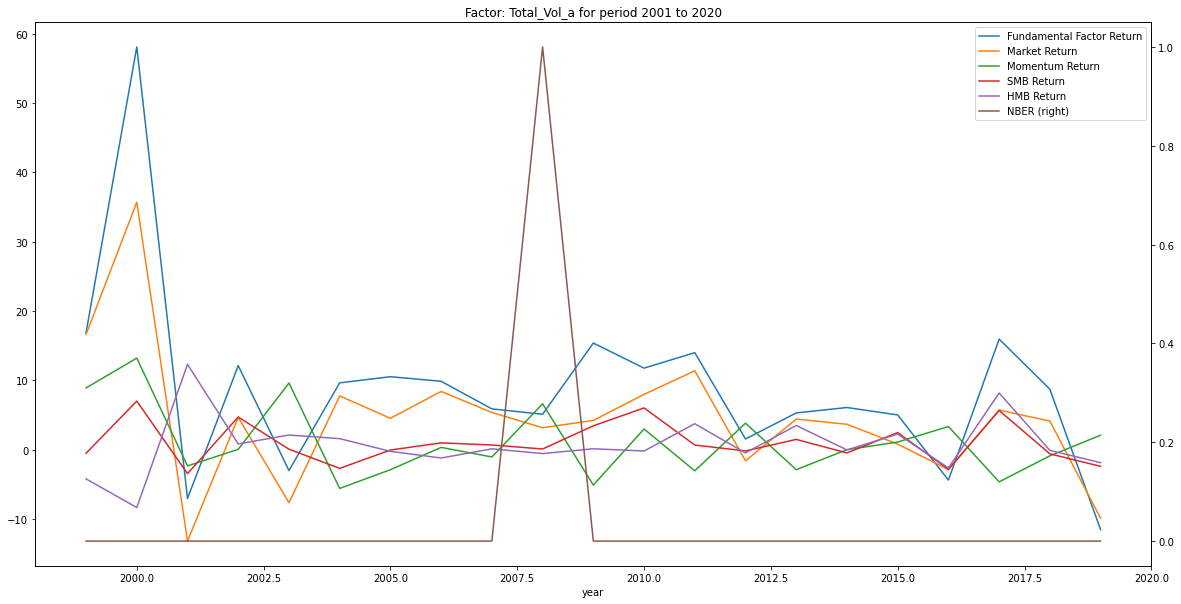

Parameters for factor: Alt_Total_Vol_a for period 1970 to 2020 :

Excess Return: 15.847485992289668
Volatility: 0.10903672408185912
Skewness: 2.7064161046880852
Kurtosis: 13.913219383467563
Sharpe Ratio: 0.5631454113117184
Information Ratio: 1.056951183800205



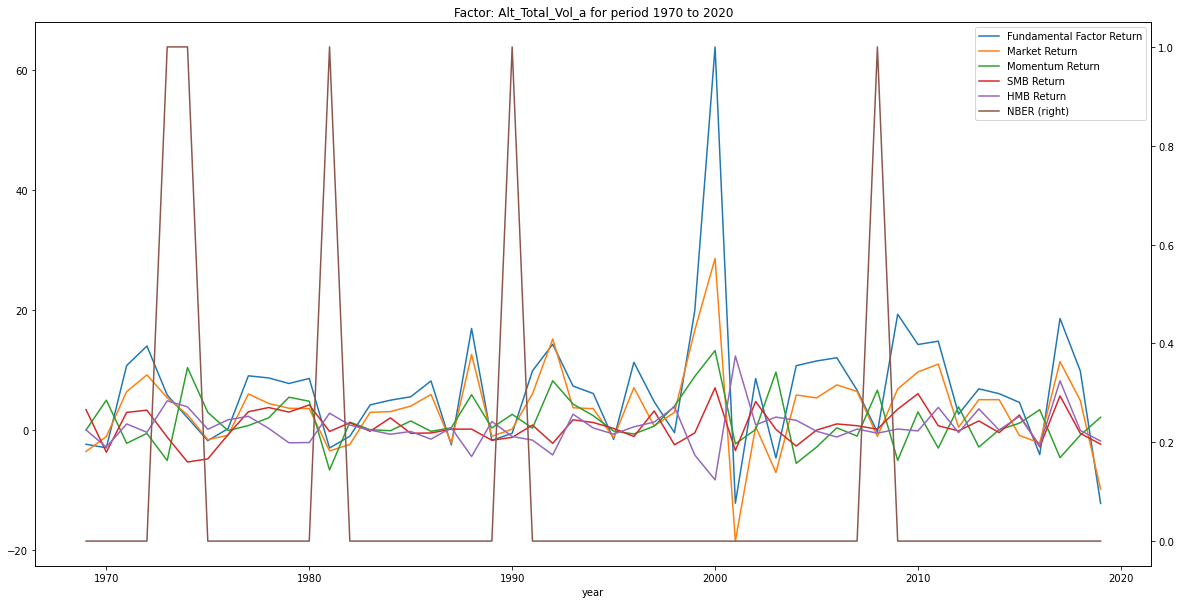

Parameters for factor: Alt_Total_Vol_a for period 1970 to 2000 :

Excess Return: 1.8101761125728428
Volatility: 0.06207561190883128
Skewness: 0.4337201651673967
Kurtosis: -0.5459948513174111
Sharpe Ratio: 0.8113250341649721
Information Ratio: 1.545142390976614



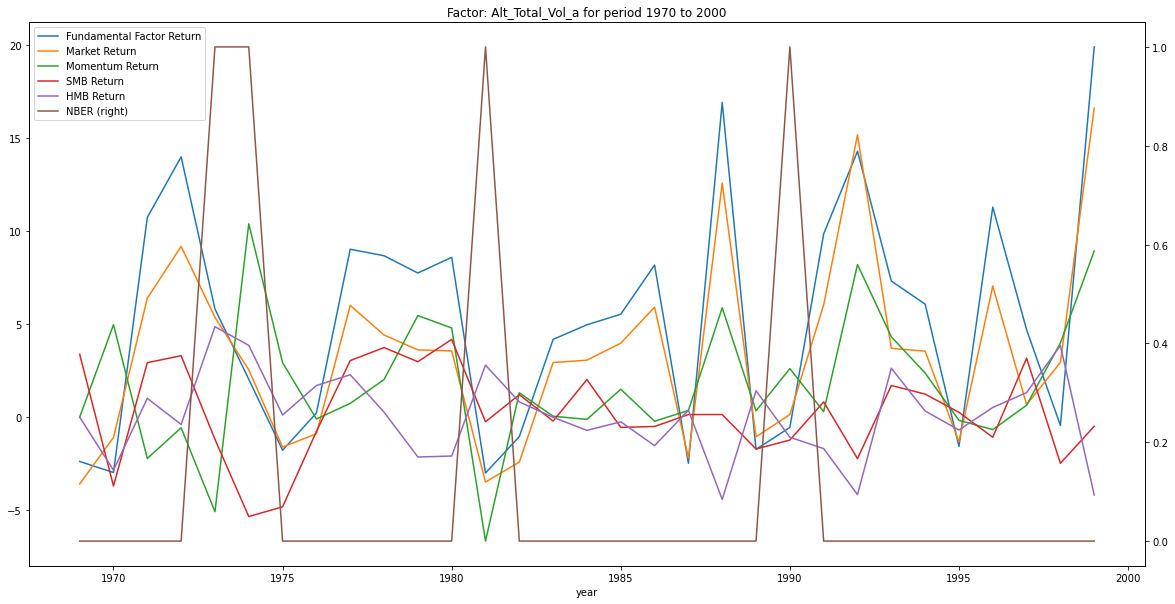

Parameters for factor: Alt_Total_Vol_a for period 2001 to 2020 :

Excess Return: 3.3427507331321684
Volatility: 0.15162355132907945
Skewness: 2.03764224930288
Kurtosis: 7.341922605666328
Sharpe Ratio: 0.5552035329828079
Information Ratio: 0.9682526042604723



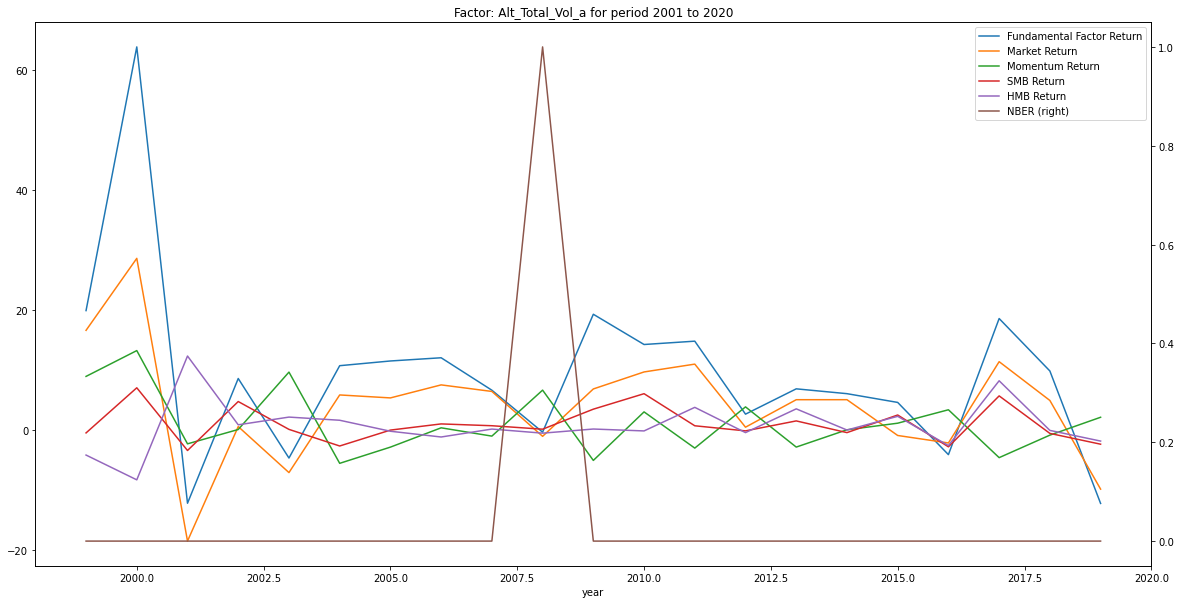

Parameters for factor: Idio_CAPM_Vol_a for period 1970 to 2020 :

Excess Return: 14.672150229451027
Volatility: 0.10517586518797697
Skewness: 3.340165809026895
Kurtosis: 18.41451479563846
Sharpe Ratio: 0.5749532709202696
Information Ratio: 1.2476188192042241



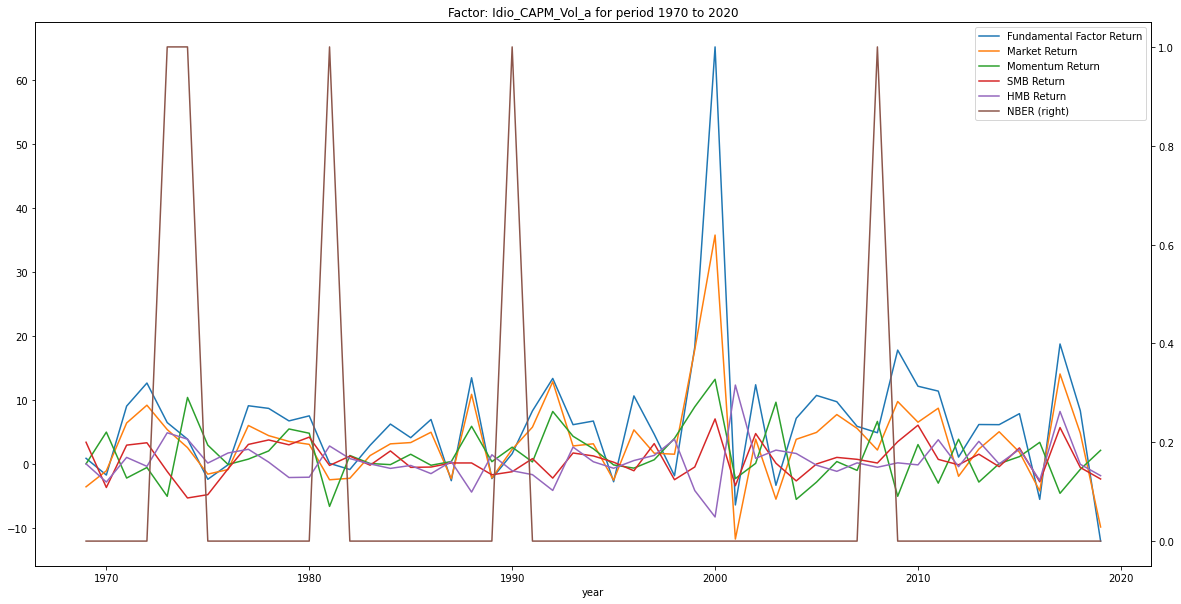

Parameters for factor: Idio_CAPM_Vol_a for period 1970 to 2000 :

Excess Return: 1.7367968598495591
Volatility: 0.05467981886894822
Skewness: 0.3380174044074416
Kurtosis: -0.4693323063160606
Sharpe Ratio: 0.8774001917480694
Information Ratio: 1.716123989103269



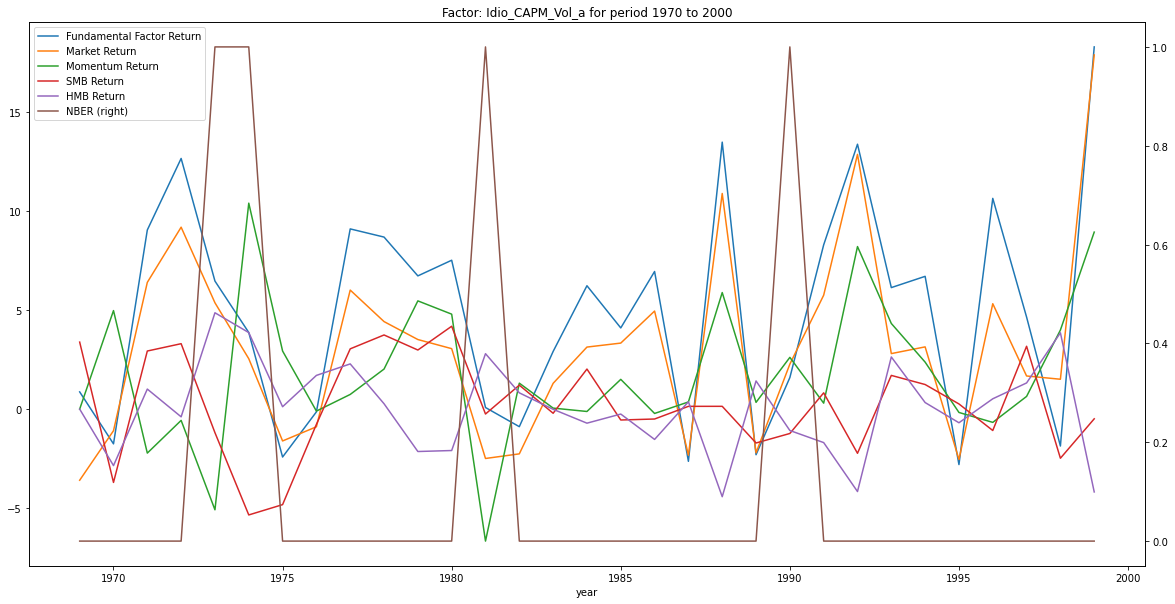

Parameters for factor: Idio_CAPM_Vol_a for period 2001 to 2020 :

Excess Return: 3.0640645935123283
Volatility: 0.14813471257159694
Skewness: 2.4785092682292316
Kurtosis: 9.380210125906252
Sharpe Ratio: 0.5724975685808286
Information Ratio: 1.1155563287849708



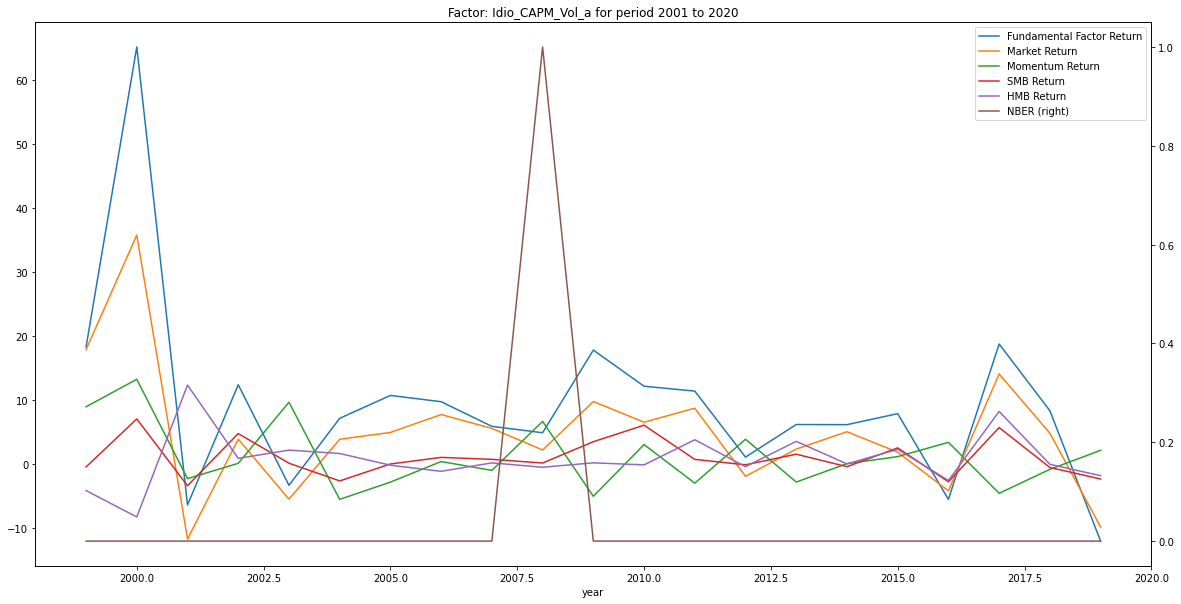

Parameters for factor: Idio_Fama3_Vol_a for period 1970 to 2020 :

Excess Return: 14.418381195961292
Volatility: 0.10126205940138941
Skewness: 3.079054060611433
Kurtosis: 16.62196937498148
Sharpe Ratio: 0.5939119005391752
Information Ratio: 1.3885904160348406



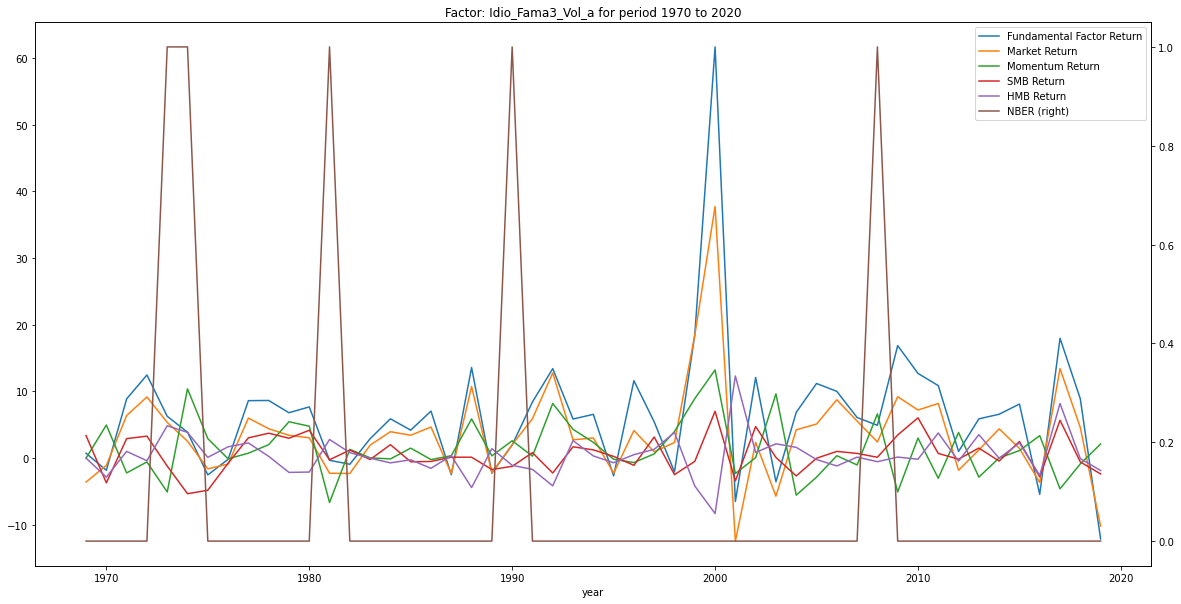

Parameters for factor: Idio_Fama3_Vol_a for period 1970 to 2000 :

Excess Return: 1.7495021478998551
Volatility: 0.05523331270602116
Skewness: 0.35078369092224987
Kurtosis: -0.4471778947401841
Sharpe Ratio: 0.8730995961951501
Information Ratio: 1.511438019972559



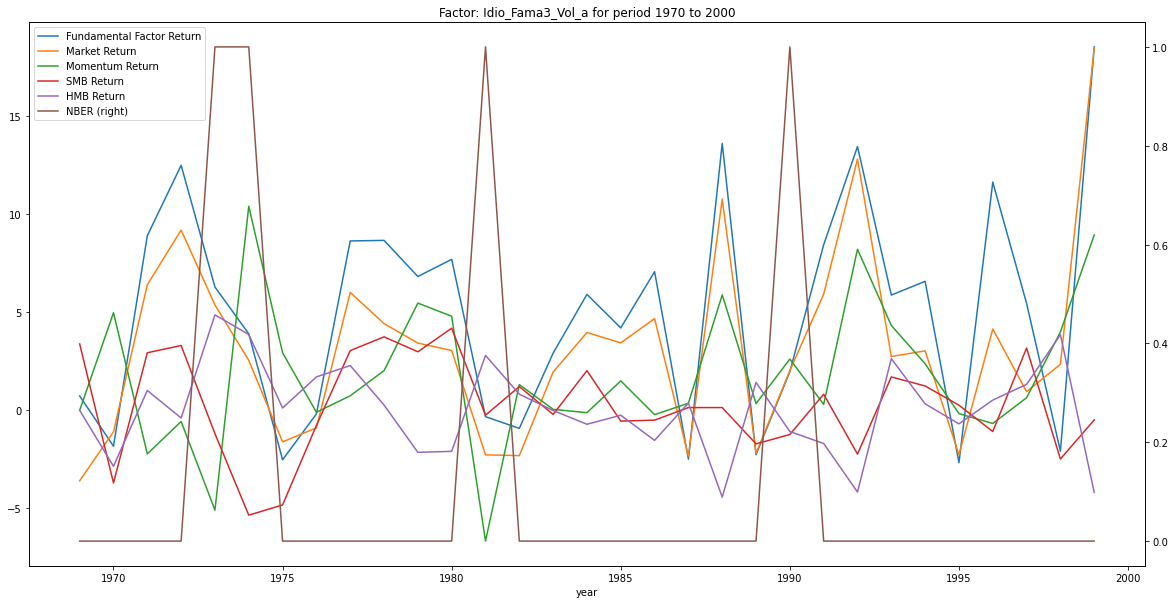

Parameters for factor: Idio_Fama3_Vol_a for period 2001 to 2020 :

Excess Return: 2.9821328725226555
Volatility: 0.14151174452207066
Skewness: 2.3112041008832267
Kurtosis: 8.670230573085773
Sharpe Ratio: 0.5915278967442197
Information Ratio: 1.2978948795278376



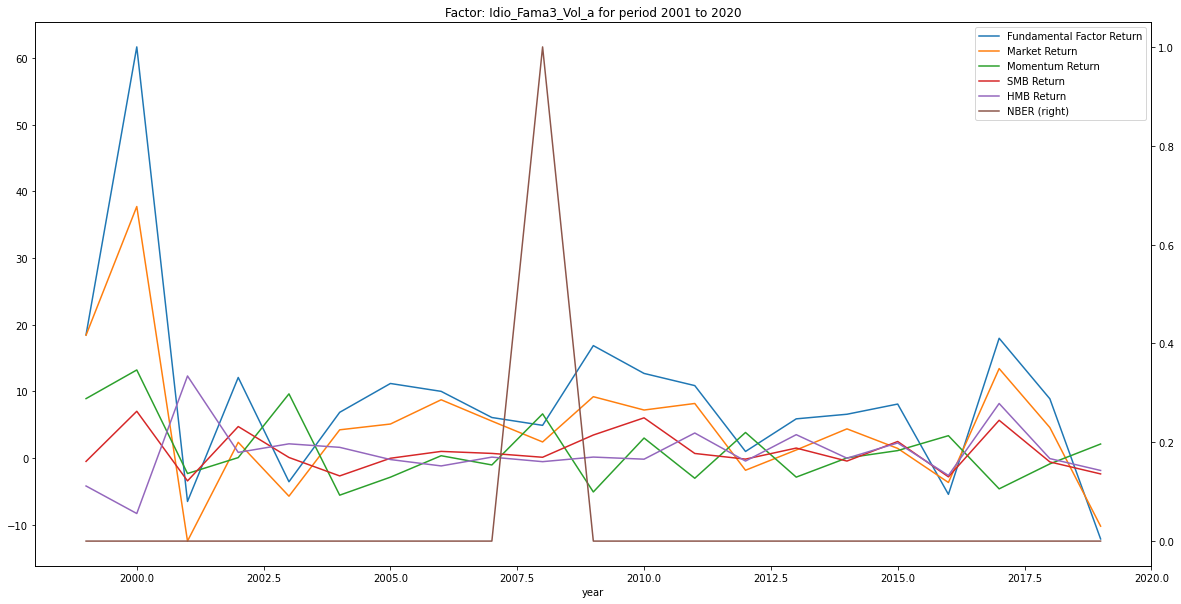

Parameters for factor: Idio_Fama4_Vol_a for period 1970 to 2020 :

Excess Return: 14.300919225388743
Volatility: 0.10130325437978732
Skewness: 3.146887950533663
Kurtosis: 17.16756436883821
Sharpe Ratio: 0.5909319937592583
Information Ratio: 1.3475746185810593



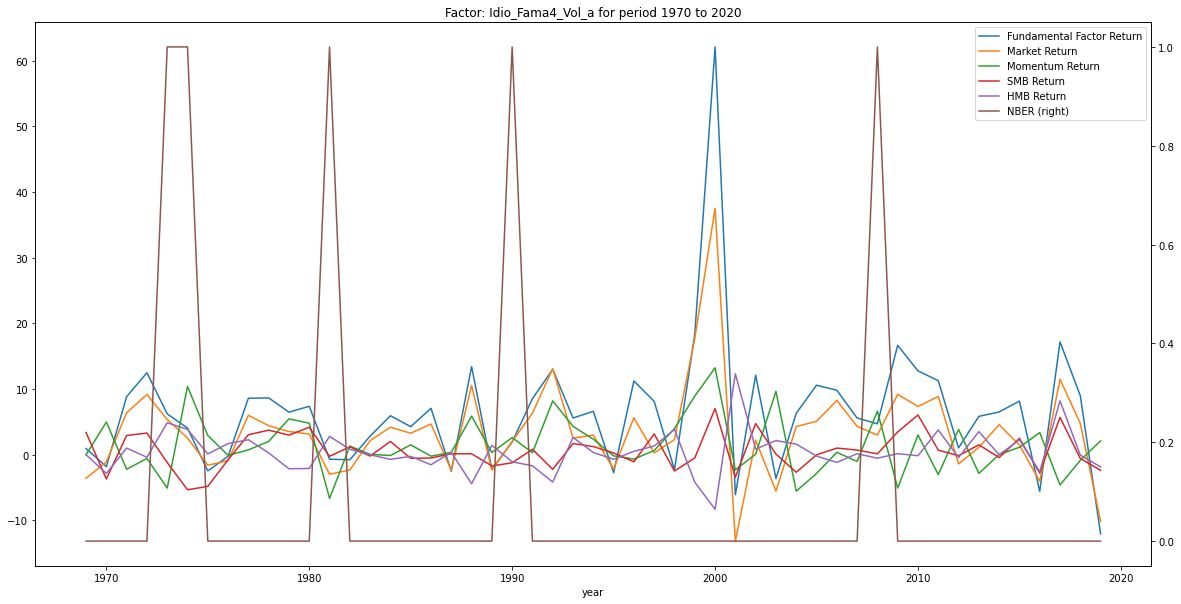

Parameters for factor: Idio_Fama4_Vol_a for period 1970 to 2000 :

Excess Return: 1.7752370345215
Volatility: 0.05501139061220225
Skewness: 0.2891703954114925
Kurtosis: -0.514959500750829
Sharpe Ratio: 0.880094290004809
Information Ratio: 1.4673434554028966



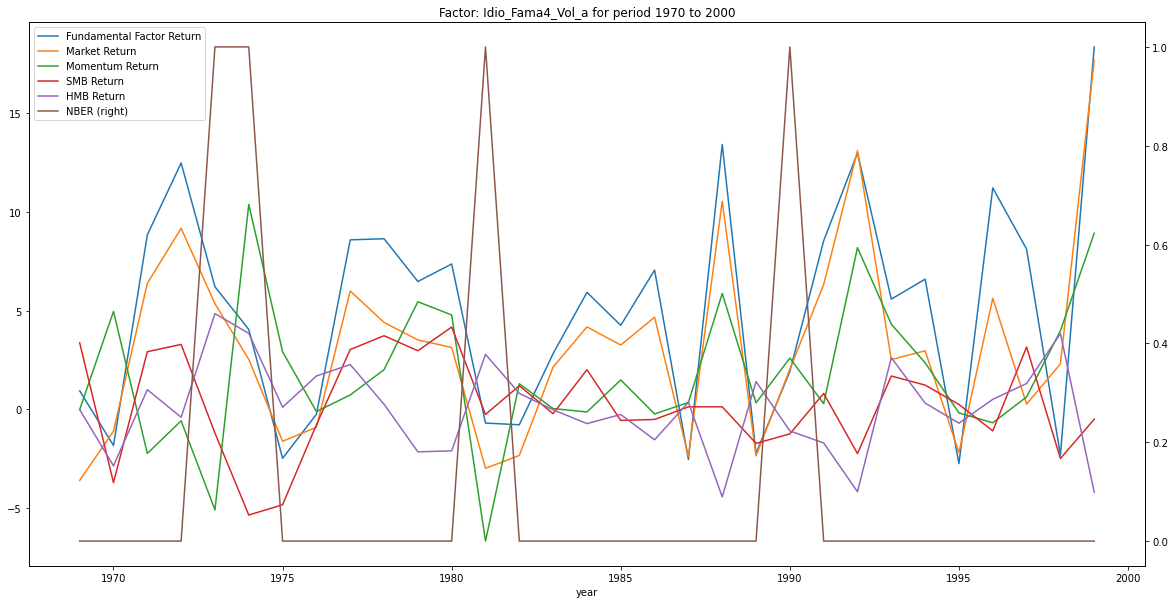

Parameters for factor: Idio_Fama4_Vol_a for period 2001 to 2020 :

Excess Return: 2.954103680412207
Volatility: 0.1418783403606656
Skewness: 2.3757601392094605
Kurtosis: 8.968056501277104
Sharpe Ratio: 0.5826665152254853
Information Ratio: 1.26252495167568



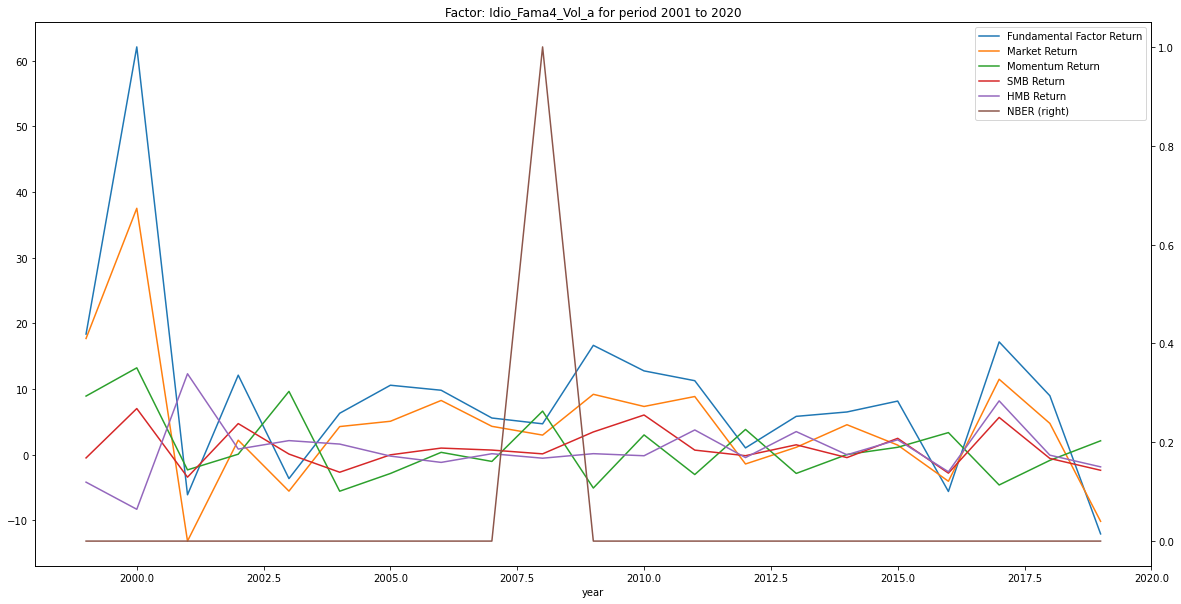

In [84]:
for factor in factor_list2:
    frame_list.append(calculate_fundamental_index_params(idio_data_annual_sample,factor,start1,end1))
    frame_list.append(calculate_fundamental_index_params(idio_data_annual_sample,factor,start2,end2))
    frame_list.append(calculate_fundamental_index_params(idio_data_annual_sample,factor,start3,end3))

## StreamLit Application (Extra Credits)

In [92]:
option = st.selectbox(
  'Select a Factor', 
   ('Book_Value','Trailing_Cash_Flow','Trailing_Gross_Sales','Trailing_Gross_Revenue','Trailing_Gross_Dividends','Trailing_Gross_Investments','Trailing_ROA','Asset_Turnover','Altman Z Score','O Score','Beta','Total_Vol_a','Alt_Total_Vol_a','Idio_CAPM_Vol_a','Idio_Fama3_Vol_a','Idio_Fama4_Vol_a'))

st.write('You selected:', option)

option_2 = st.selectbox(
  'Select period',
   ('1970-2020', '1970-2000', '2001-2020'))

st.write('You selected:', option_2)
    

if(option == 'Book_Value' and option_2 == '1970-2020'):
    st.line_chart(frame_list[0])
elif(option == 'Book_Value' and option_2 == '1970-2000'):
    st.line_chart(frame_list[1])
elif(option == 'Book_Value' and option_2 == '2001-2020'):
    st.line_chart(frame_list[2])
    
elif(option == 'Trailing_Cash_Flow' and option_2 == '1970-2020'):
    st.line_chart(frame_list[3])
elif(option == 'Trailing_Cash_Flow' and option_2 == '1970-2000'):
    st.line_chart(frame_list[4])
elif(option == 'Trailing_Cash_Flow' and option_2 == '2001-2020'):
    st.line_chart(frame_list[5])

elif(option == 'Trailing_Gross_Sales' and option_2 == '1970-2020'):
    st.line_chart(frame_list[6])
elif(option == 'Trailing_Gross_Sales' and option_2 == '1970-2000'):
    st.line_chart(frame_list[7])
elif(option == 'Trailing_Gross_Sales' and option_2 == '2001-2020'):
    st.line_chart(frame_list[8])

elif(option == 'Trailing_Gross_Revenue' and option_2 == '1970-2020'):
    st.line_chart(frame_list[9])
elif(option == 'Trailing_Gross_Revenue' and option_2 == '1970-2000'):
    st.line_chart(frame_list[10])
elif(option == 'Trailing_Gross_Revenue' and option_2 == '2001-2020'):
    st.line_chart(frame_list[1])
    
elif(option == 'Trailing_Gross_Dividends' and option_2 == '1970-2020'):
    st.line_chart(frame_list[12])
elif(option == 'Trailing_Gross_Dividends' and option_2 == '1970-2000'):
    st.line_chart(frame_list[13])
elif(option == 'Trailing_Gross_Dividends' and option_2 == '2001-2020'):
    st.line_chart(frame_list[14])    
    
elif(option == 'Trailing_Gross_Investments' and option_2 == '1970-2020'):
    st.line_chart(frame_list[15])
elif(option == 'Trailing_Gross_Investments' and option_2 == '1970-2000'):
    st.line_chart(frame_list[16])
elif(option == 'Trailing_Gross_Investments' and option_2 == '2001-2020'):
    st.line_chart(frame_list[17])
    
elif(option == 'Trailing_ROA' and option_2 == '1970-2020'):
    st.line_chart(frame_list[18])
elif(option == 'Trailing_ROA' and option_2 == '1970-2000'):
    st.line_chart(frame_list[19])
elif(option == 'Trailing_ROA' and option_2 == '2001-2020'):
    st.line_chart(frame_list[20])
    
elif(option == 'Asset_Turnover' and option_2 == '1970-2020'):
    st.line_chart(frame_list[21])
elif(option == 'Asset_Turnover' and option_2 == '1970-2000'):
    st.line_chart(frame_list[22])
elif(option == 'Asset_Turnover' and option_2 == '2001-2020'):
    st.line_chart(frame_list[23])

elif(option == 'Altman Z Score' and option_2 == '1970-2020'):
    st.line_chart(frame_list[24])
elif(option == 'Altman Z Score' and option_2 == '1970-2000'):
    st.line_chart(frame_list[25])
elif(option == 'Altman Z Score' and option_2 == '2001-2020'):
    st.line_chart(frame_list[26])
    
elif(option == 'O Score' and option_2 == '1970-2020'):
    st.line_chart(frame_list[27])
elif(option == 'O Score' and option_2 == '1970-2000'):
    st.line_chart(frame_list[28])
elif(option == 'O Score' and option_2 == '2001-2020'):
    st.line_chart(frame_list[29])
    
elif(option == 'Beta' and option_2 == '1970-2020'):
    st.line_chart(frame_list[30])
elif(option == 'Beta' and option_2 == '1970-2000'):
    st.line_chart(frame_list[31])
elif(option == 'Beta' and option_2 == '2001-2020'):
    st.line_chart(frame_list[32])
    
elif(option == 'Total_Vol_a' and option_2 == '1970-2020'):
    st.line_chart(frame_list[33])
elif(option == 'Total_Vol_a' and option_2 == '1970-2000'):
    st.line_chart(frame_list[34])
elif(option == 'Total_Vol_a' and option_2 == '2001-2020'):
    st.line_chart(frame_list[35])
    
elif(option == 'Alt_Total_Vol_a' and option_2 == '1970-2020'):
    st.line_chart(frame_list[36])
elif(option == 'Alt_Total_Vol_a' and option_2 == '1970-2000'):
    st.line_chart(frame_list[37])
elif(option == 'Alt_Total_Vol_a' and option_2 == '2001-2020'):
    st.line_chart(frame_list[38])
    
elif(option == 'Idio_CAPM_Vol_a' and option_2 == '1970-2020'):
    st.line_chart(frame_list[39])
elif(option == 'Idio_CAPM_Vol_a' and option_2 == '1970-2000'):
    st.line_chart(frame_list[40])
elif(option == 'Idio_CAPM_Vol_a' and option_2 == '2001-2020'):
    st.line_chart(frame_list[41])
    
elif(option == 'Idio_Fama3_Vol_a' and option_2 == '1970-2020'):
    st.line_chart(frame_list[42])
elif(option == 'Idio_Fama3_Vol_a' and option_2 == '1970-2000'):
    st.line_chart(frame_list[43])
elif(option == 'Idio_Fama3_Vol_a' and option_2 == '2001-2020'):
    st.line_chart(frame_list[44])
    
elif(option == 'Idio_Fama4_Vol_a' and option_2 == '1970-2020'):
    st.line_chart(frame_list[45])
elif(option == 'Idio_Fama4_Vol_a' and option_2 == '1970-2000'):
    st.line_chart(frame_list[46])
elif(option == 'Idio_Fama4_Vol_a' and option_2 == '2001-2020'):
    st.line_chart(frame_list[47])

2022-10-29 05:44:38.222 
  command:

    streamlit run C:\Users\Pradhyumn Singh\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
